# Churn Analysis for prepaid lines

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Profiling and Sanity Check</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> Churn Analysis is one of the most popular data use cases in Telecom. The data collected on STC customers, with a focus on prepaid customers. Analysis on the provided dataset will help the company understand its customers and their behavior. This, in turn, would help the company prevent customer churn or predict customers who are likely to cancel their subscription.

### Imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from plotly.graph_objs import Scatter, Layout, Figure, Data, Stream, YAxis, Marker
import cufflinks as cf
import plotly.offline as pyo
pyo.init_notebook_mode()
cf.go_offline()
cf.set_config_file(offline=False, world_readable=False)

### Helper functions

In [2]:
def get_null_count(df):
    null_count = {}
    for col in list(df.columns):
        null_count[col] = sum(df[col].isnull())

    return sorted(null_count.items(), key=lambda x: x[1], reverse= True)

def threshold(x):
    #thresholding last usage date
    if x <= 15:
        return 1
    elif x <=30:
        return 2
    else:
        return 3

### Loading Data

In [3]:
base_df = pd.read_csv('dataset/Base.csv')
balance_df = pd.read_csv('dataset/Balance Transfer.csv', sep='\t', index_col=0)
cc_df = pd.read_csv('dataset/CC Events.csv', sep='\t', index_col=0)
recharge_df = pd.read_csv('dataset/Recharges.csv', index_col=0)
usage_df = pd.read_csv('dataset/Usage.csv')

### Loading Check

In [4]:
base_df.head()

Subscriber_ID GENDER_TYPE_CD   BIRTH_DT LINE_SUBSCRIPTION_DATE  \
0            273           MALE   7-Oct-92              11-Jul-17   
1            983           MALE  10-Jan-59              14-Jan-18   
2            325           MALE  22-Aug-71              12-Feb-17   
3            460           MALE   5-Jan-79               4-Mar-17   
4            319         FEMALE  24-Apr-78              14-Oct-12   

   LAST_USAGE_DATE  LAST_CALL_DATE  LAST_CALL_DATE_ONNET  \
0               14              38                  38.0   
1               28              28                  28.0   
2               10              10                  44.0   
3              191             200                 200.0   
4               72              73                  73.0   

   LAST_CALL_DATE_OFFNET  LAST_CALL_DATE_INT  LAST_SMS_DATE  ...  \
0                  170.0                 NaN           14.0  ...   
1                  458.0                28.0           47.0  ...   
2                   10.0              1229.0           57.0  ...   
3                 1173.0               561.0          191.0  ...   
4                  114.0                 NaN           76.0  ...   

   PP_LAST_DATA_DATE_SB  PP_ACTIVATION_DATE  PP_REVENUE_LAST_1MON  \
0                 140.0           11-Jul-17                  0.41   
1                   NaN           14-Jan-18                 53.30   
2                  44.0           12-Feb-17                  0.00   
3                 305.0            5-Mar-17                  0.00   
4                  72.0           16-Apr-11                  0.00   

   PP_REVENUE_LAST_3MON    ARPU                               BRAND_MODEL  \
0                 40.18   22.19             Samsung N9005 Galaxy Note III   
1               1017.17  527.47             Huawei Y7 Prime 2018 Dual Sim   
2                 65.24   50.24  Samsung SM-G532 Galaxy J2 Prime Dual Sim   
3                  0.00   15.51    Samsung SM-A710 Galaxy A7 LTE Dual Sim   
4                  4.65  160.25                            Apple iPhone 6   

   Unnamed: 63  Unnamed: 64  Unnamed: 65  Unnamed: 66  
0          NaN          NaN          NaN          NaN  
1          NaN          NaN          NaN          NaN  
2          NaN          NaN          NaN          NaN  
3          NaN          NaN          NaN          NaN  
4          NaN          NaN          NaN          NaN  

[5 rows x 67 columns]

In [5]:
balance_df.head()

TXN_DT  TRNSFR_AMT  SRC_ACCS_METH_VAL  TRGT_ACCS_METH_VAL  \
1  24-Jan-2019        20.0                NaN               538.0   
2  23-Feb-2019        20.0                NaN               538.0   
3  24-Jan-2019        20.0                NaN               538.0   
4  23-Feb-2019        20.0                NaN               538.0   
5  28-Feb-2019        10.0                NaN               222.0   

   SRC_BAL_BFRE_AMT  TRGT_BAL_BFRE_AMT  SRC_BAL_AFTR_AMT  TRGT_BAL_AFTR_AMT  
1            784.64              61.52            764.64              81.52  
2            366.84             120.67            346.84             140.67  
3            805.14              41.52            785.14              61.52  
4            407.84              80.67            387.84             100.67  
5             77.22               0.52             67.22              10.52

In [6]:
cc_df.head()

Subscriber_ID CNTCT_EVNT_TM CNTCT_AREA_NME         CNTCT_AREA_TYP_NME  \
1            360      16:53:58        General            Change Language   
2            618      18:55:12        General            Change Language   
3            618      10:51:39        General            Change Language   
4            676      01:38:38        Service  Prepaid Cancel Connection   
5            752      05:50:16        Service    Temporary Disconnection   

  CNTCT_EVNT_TYP_CD EXP_CLOSE_DT EXP_CLOSE_TM        EVNT_STRT_DTTM  \
1                 R  25-Feb-2019     16:53:58  24-Feb-2019 16:53:58   
2                 R  15-Jan-2019     18:55:12  14-Jan-2019 18:55:12   
3                 R  06-Jan-2019     10:51:39  05-Jan-2019 10:51:39   
4                 R  08-Apr-2019     07:00:00  01-Apr-2019 01:38:38   
5                 R  02-Apr-2019     07:00:00  01-Apr-2019 05:50:16   

          EVNT_END_DTTM CNTCT_TIER_CD CNTCT_CLSFCTON_CD     DUR  COMMIT_DUR  
1  24-Feb-2019 16:53:59        Tier 2         Technical    0.00        24.0  
2  14-Jan-2019 18:55:12        Tier 2         Technical    0.00        24.0  
3  05-Jan-2019 10:51:40        Tier 2         Technical    0.00        24.0  
4  05-Apr-2019 05:39:18        Tier 2         Technical  100.02       168.0  
5  01-Apr-2019 06:54:12        Tier 2         Technical    1.07        24.0

In [7]:
recharge_df.head()

RCHRG_DT  Subscriber_ID  RCHRG_DNM_TYP_VAL FRST_RCHRG_TME LST_RCHRG_TME  \
1  12-Jan-19            882                 15        0:15:37       0:15:37   
2   2-Jan-19            934                 15       12:33:00      12:33:00   
3   9-Jan-19            316                 15       15:45:01      15:45:01   
4   5-Jan-19            125                 15       22:35:24      22:35:24   
5  10-Jan-19            169                 20       12:19:15      12:19:15   

  RCHRG_PP_CRD_CHNL  MIN_RCHRG_AMT  MAX_RCHRG_AMT  TOTAL_RCHRG_AMT  \
1          PHYSICAL          15.24          15.24            15.24   
2          PHYSICAL          15.24          15.24            15.24   
3          PHYSICAL          15.24          15.24            15.24   
4          PHYSICAL          15.00          15.00            15.00   
5          PHYSICAL          20.00          20.00            20.00   

   ACTL_RCHRG_AMT  TOTAL_NMBR_OF_RCHRG_CNT UNIT_OF_MSR  
1            15.0                        1         SAR  
2            15.0                        1         SAR  
3            15.0                        1         SAR  
4            15.0                        1         SAR  
5            20.0                        1         SAR

In [8]:
usage_df.head()

TXN_DT  TXN_TME_HOUR  Subscriber_ID USG_CHRGD_FLG USG_SUB_TYP_NME  \
0   1-Jan-19            20            625             Y            Data   
1   1-Jan-19            17            258             Y           Voice   
2   1-Jan-19            11            742             N           Voice   
3  14-Jan-19            22            887             Y           Voice   
4   1-Jan-19            10            596             Y           Voice   

  USG_CTGRY_NME USG_ROAM_FLG  TXN_REV_AMT  TXN_REV_ACTL_AMT  TXN_CNT  TXN_DUR  \
0         PayGo            N     0.195313          0.195313        1        0   
1         Onnet            N     1.375000          1.375000        1      140   
2         Onnet            N     0.000000          0.000000        1      124   
3         Onnet            N     0.275000          0.275000        1       11   
4          Zain            N     3.575000          3.575000        6      291   

   INC_DATA_VOL  OUT_DATA_VOL  
0          1898             0  
1             0             0  
2             0             0  
3             0             0  
4             0             0

<a id='Data Profiling and Sanity Check'></a>
## Data Profiling and Sanity Check

### Base Table

#### Checking Datasize

In [9]:
base_df.shape

(1000, 67)

Base Table has 1000 records with 67 features, detected number of features is higher than expected, quick look shows that 4 unnamed columns were included, maybe an error during extraction, can be easily fixed in pandas

#### Correcting Base Table Reading

In [10]:
base_df = base_df.iloc[:,:-4]

In [11]:
base_df.head()

Subscriber_ID GENDER_TYPE_CD   BIRTH_DT LINE_SUBSCRIPTION_DATE  \
0            273           MALE   7-Oct-92              11-Jul-17   
1            983           MALE  10-Jan-59              14-Jan-18   
2            325           MALE  22-Aug-71              12-Feb-17   
3            460           MALE   5-Jan-79               4-Mar-17   
4            319         FEMALE  24-Apr-78              14-Oct-12   

   LAST_USAGE_DATE  LAST_CALL_DATE  LAST_CALL_DATE_ONNET  \
0               14              38                  38.0   
1               28              28                  28.0   
2               10              10                  44.0   
3              191             200                 200.0   
4               72              73                  73.0   

   LAST_CALL_DATE_OFFNET  LAST_CALL_DATE_INT  LAST_SMS_DATE  ...  \
0                  170.0                 NaN           14.0  ...   
1                  458.0                28.0           47.0  ...   
2                   10.0              1229.0           57.0  ...   
3                 1173.0               561.0          191.0  ...   
4                  114.0                 NaN           76.0  ...   

   PP_LAST_SMS_DATE_ONNET  PP_LAST_SMS_DATE_OFFNET  PP_LAST_DATA_DATE  \
0                   168.0                     71.0               29.0   
1                     NaN                      NaN                NaN   
2                    57.0                      NaN               51.0   
3                     NaN                      NaN              199.0   
4                    76.0                    206.0              669.0   

   PP_LAST_DATA_DATE_PG  PP_LAST_DATA_DATE_SB  PP_ACTIVATION_DATE  \
0                  29.0                 140.0           11-Jul-17   
1                   NaN                   NaN           14-Jan-18   
2                  51.0                  44.0           12-Feb-17   
3                 199.0                 305.0            5-Mar-17   
4                 669.0                  72.0           16-Apr-11   

   PP_REVENUE_LAST_1MON  PP_REVENUE_LAST_3MON    ARPU  \
0                  0.41                 40.18   22.19   
1                 53.30               1017.17  527.47   
2                  0.00                 65.24   50.24   
3                  0.00                  0.00   15.51   
4                  0.00                  4.65  160.25   

                                BRAND_MODEL  
0             Samsung N9005 Galaxy Note III  
1             Huawei Y7 Prime 2018 Dual Sim  
2  Samsung SM-G532 Galaxy J2 Prime Dual Sim  
3    Samsung SM-A710 Galaxy A7 LTE Dual Sim  
4                            Apple iPhone 6  

[5 rows x 63 columns]

In [12]:
base_df.shape

(1000, 63)

After fixing the extra Columns issue, the real number of records is 996, with 63 features

#### General info and Statistics

In [13]:
base_df.describe()

Subscriber_ID  LAST_USAGE_DATE  LAST_CALL_DATE  LAST_CALL_DATE_ONNET  \
count    1000.000000      1000.000000     1000.000000            998.000000   
mean      500.500000       104.160000      128.035000            142.907816   
std       288.819436       199.497257      228.120321            236.651960   
min         1.000000         0.000000        0.000000              0.000000   
25%       250.750000         0.000000        3.000000              5.000000   
50%       500.500000        26.000000       28.000000             33.000000   
75%       750.250000        72.250000      117.500000            150.750000   
max      1000.000000      1012.000000     1163.000000           1212.000000   

       LAST_CALL_DATE_OFFNET  LAST_CALL_DATE_INT  LAST_SMS_DATE  \
count             983.000000          811.000000     990.000000   
mean              330.919634          504.636252     195.660606   
std               393.107758          514.641239     266.930456   
min                 0.000000            0.000000       0.000000   
25%                32.000000           39.000000      28.000000   
50%               145.000000          321.000000      70.500000   
75%               497.000000          941.500000     263.750000   
max              1731.000000         1725.000000    1548.000000   

       LAST_SMS_DATE_ONNET  LAST_SMS_DATE_OFFNET  LAST_SMS_DATE_INT  ...  \
count           952.000000            772.000000         807.000000  ...   
mean            365.012605            532.586788         434.377943  ...   
std             413.917521            470.795302         457.135717  ...   
min               0.000000              0.000000           0.000000  ...   
25%              51.000000            157.000000          74.000000  ...   
50%             170.000000            346.000000         236.000000  ...   
75%             561.250000            815.250000         672.000000  ...   
max            1724.000000           1721.000000        1725.000000  ...   

       PP_LAST_SMS_DATE  PP_LAST_SMS_DATE_INT  PP_LAST_SMS_DATE_ONNET  \
count        969.000000            696.000000              859.000000   
mean         180.250774            329.037356              281.643772   
std          237.365817            378.345488              324.574868   
min            1.000000              1.000000                1.000000   
25%           28.000000             57.750000               50.000000   
50%           67.000000            193.500000              132.000000   
75%          250.000000            467.250000              420.500000   
max         1467.000000           2293.000000             2425.000000   

       PP_LAST_SMS_DATE_OFFNET  PP_LAST_DATA_DATE  PP_LAST_DATA_DATE_PG  \
count               615.000000         762.000000            635.000000   
mean                453.401626         308.933071            386.705512   
std                 414.046512         309.596188            335.680372   
min                   1.000000           1.000000              1.000000   
25%                 136.000000          55.750000             90.500000   
50%                 331.000000         210.000000            309.000000   
75%                 659.000000         481.000000            617.500000   
max                2234.000000        2098.000000           2098.000000   

       PP_LAST_DATA_DATE_SB  PP_REVENUE_LAST_1MON  PP_REVENUE_LAST_3MON  \
count            806.000000           1000.000000           1000.000000   
mean             188.578164             43.215410            166.645970   
std              283.311611             69.035434            279.375491   
min                1.000000              0.000000              0.000000   
25%               10.000000              0.000000              0.000000   
50%               53.000000              4.320000             56.710000   
75%              266.250000             66.047500            250.620000   
max             2078.000000            484.320000           2950.500000 

A quick look on statistics shows a clear volatility in terms of data, indicated by the huge standard deviation

In [14]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 63 columns):
Subscriber_ID                     1000 non-null int64
GENDER_TYPE_CD                    994 non-null object
BIRTH_DT                          1000 non-null object
LINE_SUBSCRIPTION_DATE            1000 non-null object
LAST_USAGE_DATE                   1000 non-null int64
LAST_CALL_DATE                    1000 non-null int64
LAST_CALL_DATE_ONNET              998 non-null float64
LAST_CALL_DATE_OFFNET             983 non-null float64
LAST_CALL_DATE_INT                811 non-null float64
LAST_SMS_DATE                     990 non-null float64
LAST_SMS_DATE_ONNET               952 non-null float64
LAST_SMS_DATE_OFFNET              772 non-null float64
LAST_SMS_DATE_INT                 807 non-null float64
LAST_DATA_DATE                    908 non-null float64
LAST_RECHARGE_DATE                910 non-null float64
LAST_RECHARGE_DATE_10SAR          635 non-null float64
LAST_RECHARGE_DATE

Info indicates a number of empty cells

#### Null Counts

In [15]:
get_null_count(base_df)

[('LAST_RECHARGE_DATE_OTHER', 996),
 ('LAST_RECHARGE_DATE_300SAR', 970),
 ('PP_FIRST_NEGATIVE_BALANCE_DATE', 738),
 ('PP_LAST_NEGATIVE_BALANCE_DATE', 737),
 ('PP_FIRST_ROAMING_DATE', 722),
 ('PP_LAST_ROAMING_DATE', 722),
 ('LAST_RECHARGE_DATE_100SAR', 624),
 ('LAST_RECHARGE_DATE_50SAR', 424),
 ('PP_FIRST_SMS_DATE_OFFNET', 385),
 ('PP_LAST_SMS_DATE_OFFNET', 385),
 ('PP_FIRST_DATA_DATE_PG', 366),
 ('LAST_RECHARGE_DATE_10SAR', 365),
 ('PP_LAST_DATA_DATE_PG', 365),
 ('PP_FIRST_CALL_DATE_INT', 352),
 ('PP_LAST_CALL_DATE_INT', 352),
 ('PP_FIRST_SMS_DATE_INT', 305),
 ('PP_LAST_SMS_DATE_INT', 304),
 ('LAST_RECHARGE_DATE_20SAR', 248),
 ('PP_FIRST_DATA_DATE', 239),
 ('PP_LAST_DATA_DATE', 238),
 ('LAST_SMS_DATE_OFFNET', 228),
 ('PP_FIRST_DATA_DATE_SB', 194),
 ('PP_LAST_DATA_DATE_SB', 194),
 ('LAST_SMS_DATE_INT', 193),
 ('LAST_CALL_DATE_INT', 189),
 ('PP_FIRST_SMS_DATE_ONNET', 142),
 ('PP_LAST_SMS_DATE_ONNET', 141),
 ('PP_FIRST_CALL_DATE_OFFNET', 96),
 ('PP_LAST_CALL_DATE_OFFNET', 96),
 ('LAST_DAT

Some columns are mostly empty, which needs to be noted for better analytics

#### Duplication

In [16]:
sum(base_df.duplicated())

0

There are no duplications

#### Unique Values

In [17]:
base_df.nunique()

Subscriber_ID                    1000
GENDER_TYPE_CD                      2
BIRTH_DT                          504
LINE_SUBSCRIPTION_DATE            565
LAST_USAGE_DATE                   227
LAST_CALL_DATE                    266
LAST_CALL_DATE_ONNET              268
LAST_CALL_DATE_OFFNET             421
LAST_CALL_DATE_INT                407
LAST_SMS_DATE                     340
LAST_SMS_DATE_ONNET               448
LAST_SMS_DATE_OFFNET              438
LAST_SMS_DATE_INT                 395
LAST_DATA_DATE                    344
LAST_RECHARGE_DATE                238
LAST_RECHARGE_DATE_10SAR          250
LAST_RECHARGE_DATE_20SAR          264
LAST_RECHARGE_DATE_50SAR          232
LAST_RECHARGE_DATE_100SAR         170
LAST_RECHARGE_DATE_300SAR           7
LAST_RECHARGE_DATE_OTHER            3
RECHARGE_AMOUNT_6MON              319
ACTUAL_RECHARGE_AMOUNT_6MON       178
FIRST_IVR_CALL_DONE_FLAG            2
FIRST_CALL_DONE_FLAG                2
LANGUAGE_ID                         4
SERVICE_FEE_

The number of uniques indicates that all categorical fields are well, and also shows interesting information such as the number of times users recharged using 300SR cards and the number of languages supported and more.

### Balance Transfers Table

#### Checking Data size

In [18]:
balance_df.shape

(38, 8)

This shows that there are 38 transactions recorded, with 8 features, which is correct since the 9th is the index, in conformance with provided data description

#### General Statistics and Info

In [19]:
balance_df.describe()

TRNSFR_AMT  SRC_ACCS_METH_VAL  TRGT_ACCS_METH_VAL  SRC_BAL_BFRE_AMT  \
count   38.000000                1.0           37.000000         38.000000   
mean    16.447368              820.0          441.405405        338.910526   
std      5.186768                NaN          262.055068        293.683213   
min      5.000000              820.0           56.000000         30.460000   
25%     10.000000              820.0          222.000000         87.067500   
50%     20.000000              820.0          538.000000        229.260000   
75%     20.000000              820.0          538.000000        634.065000   
max     20.000000              820.0          902.000000        846.140000   

       TRGT_BAL_BFRE_AMT  SRC_BAL_AFTR_AMT  TRGT_BAL_AFTR_AMT  
count          38.000000         38.000000          38.000000  
mean           40.668947        322.463158          57.116316  
std            53.259977        291.124811          56.070067  
min            -5.290000         20.460000           4.710000  
25%             0.765000         67.922500          13.320000  
50%            10.405000        210.040000          25.695000  
75%            75.882500        614.065000          95.882500  
max           161.520000        826.140000         181.520000

Statstics here are very interesting, since it shows that transaction amounts are pretty close to each other (either 20 or 10) might indicated fixed values, while the balances differ.
but also shows that we have a majorly empty column

In [20]:
balance_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 1 to 38
Data columns (total 8 columns):
TXN_DT                38 non-null object
TRNSFR_AMT            38 non-null float64
SRC_ACCS_METH_VAL     1 non-null float64
TRGT_ACCS_METH_VAL    37 non-null float64
SRC_BAL_BFRE_AMT      38 non-null float64
TRGT_BAL_BFRE_AMT     38 non-null float64
SRC_BAL_AFTR_AMT      38 non-null float64
TRGT_BAL_AFTR_AMT     38 non-null float64
dtypes: float64(7), object(1)
memory usage: 2.7+ KB


info shows that most columns are filled, apart from source access method value which only has 1 non-empty cell, also target access method value is missing one cell.

#### Null Counts

In [21]:
get_null_count(balance_df)

[('SRC_ACCS_METH_VAL', 37),
 ('TRGT_ACCS_METH_VAL', 1),
 ('TXN_DT', 0),
 ('TRNSFR_AMT', 0),
 ('SRC_BAL_BFRE_AMT', 0),
 ('TRGT_BAL_BFRE_AMT', 0),
 ('SRC_BAL_AFTR_AMT', 0),
 ('TRGT_BAL_AFTR_AMT', 0)]

#### Duplicates

In [22]:
sum(balance_df.duplicated())

0

There are no dupliactions

#### Unique Values

In [23]:
balance_df.nunique()

TXN_DT                14
TRNSFR_AMT             4
SRC_ACCS_METH_VAL      1
TRGT_ACCS_METH_VAL     8
SRC_BAL_BFRE_AMT      37
TRGT_BAL_BFRE_AMT     35
SRC_BAL_AFTR_AMT      37
TRGT_BAL_AFTR_AMT     35
dtype: int64

The number of uniques indicates that transaction amounts are of fixed values, we can see 4 of them.

### CC Events

#### Checking Data Size

In [24]:
cc_df.shape

(124, 13)

The shape indicates that there are 124 customer care tickets registered, each with 13 featues, which confirms the provided data description since the 14th is the index

#### General Statistics and Info

In [25]:
cc_df.describe()

Subscriber_ID         DUR  COMMIT_DUR
count     124.000000  124.000000  124.000000
mean      497.233871    3.185081   26.903226
std       189.509899   17.465132   23.624921
min        69.000000    0.000000    0.000000
25%       400.500000    0.000000   24.000000
50%       429.000000    0.000000   24.000000
75%       618.000000    0.000000   24.000000
max       958.000000  100.020000  168.000000

Statistics shows that the duration is highly variant and affected by outliers, also it shows that most of the data are not recorded properly since percentiles in duration are mostly zero.

In [26]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124 entries, 1 to 124
Data columns (total 13 columns):
Subscriber_ID         124 non-null int64
CNTCT_EVNT_TM         124 non-null object
CNTCT_AREA_NME        124 non-null object
CNTCT_AREA_TYP_NME    124 non-null object
CNTCT_EVNT_TYP_CD     124 non-null object
EXP_CLOSE_DT          124 non-null object
EXP_CLOSE_TM          124 non-null object
EVNT_STRT_DTTM        124 non-null object
EVNT_END_DTTM         124 non-null object
CNTCT_TIER_CD         124 non-null object
CNTCT_CLSFCTON_CD     124 non-null object
DUR                   124 non-null float64
COMMIT_DUR            124 non-null float64
dtypes: float64(2), int64(1), object(10)
memory usage: 13.6+ KB


info shows that there are no empty cells

#### Null Counter

In [27]:
get_null_count(cc_df)

[('Subscriber_ID', 0),
 ('CNTCT_EVNT_TM', 0),
 ('CNTCT_AREA_NME', 0),
 ('CNTCT_AREA_TYP_NME', 0),
 ('CNTCT_EVNT_TYP_CD', 0),
 ('EXP_CLOSE_DT', 0),
 ('EXP_CLOSE_TM', 0),
 ('EVNT_STRT_DTTM', 0),
 ('EVNT_END_DTTM', 0),
 ('CNTCT_TIER_CD', 0),
 ('CNTCT_CLSFCTON_CD', 0),
 ('DUR', 0),
 ('COMMIT_DUR', 0)]

#### Duplicates

In [28]:
sum(cc_df.duplicated())

0

There are no dupliacates

#### Unique Values

In [29]:
cc_df.nunique()

Subscriber_ID         66
CNTCT_EVNT_TM         33
CNTCT_AREA_NME         4
CNTCT_AREA_TYP_NME     6
CNTCT_EVNT_TYP_CD      2
EXP_CLOSE_DT          24
EXP_CLOSE_TM          22
EVNT_STRT_DTTM        33
EVNT_END_DTTM         33
CNTCT_TIER_CD          2
CNTCT_CLSFCTON_CD      2
DUR                    5
COMMIT_DUR             5
dtype: int64

Unique values shows that on average, most customers made two complaints, indicated by the number of recorded tickets and unique subscriber ids

### Recharges

### Check Data Size

In [30]:
recharge_df.shape

(6956, 12)

shape shows us that there are 6956 recharge transcations recorded, each has 12 features and an index, which confirms with data description

#### General Statistics and Info

In [31]:
recharge_df.describe()

Subscriber_ID  RCHRG_DNM_TYP_VAL  MIN_RCHRG_AMT  MAX_RCHRG_AMT  \
count    6956.000000        6956.000000    6955.000000    6955.000000   
mean      521.636429       -1397.147067      26.392496      26.392496   
std       263.064705       11848.628916      28.847108      28.847108   
min         1.000000      -99999.000000     -20.500000     -20.500000   
25%       347.000000          15.000000      15.240000      15.240000   
50%       523.000000          20.000000      20.000000      20.000000   
75%       749.000000          25.000000      25.000000      25.000000   
max      1000.000000         333.000000     333.000000     333.000000   

       TOTAL_RCHRG_AMT  ACTL_RCHRG_AMT  TOTAL_NMBR_OF_RCHRG_CNT  
count      6955.000000     6857.000000              6956.000000  
mean         27.891901       27.965728                 1.057073  
std          30.952123       31.084991                 0.287867  
min         -40.000000        0.000000                 1.000000  
25%          15.240000       15.000000                 1.000000  
50%          20.000000       20.000000                 1.000000  
75%          30.000000       30.000000                 1.000000  
max         333.000000      333.000000                 9.000000

Statistics shows corruption in Recharge Denim Type Value.

In [32]:
recharge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6956 entries, 1 to 6956
Data columns (total 12 columns):
RCHRG_DT                   6956 non-null object
Subscriber_ID              6956 non-null int64
RCHRG_DNM_TYP_VAL          6956 non-null int64
FRST_RCHRG_TME             6956 non-null object
LST_RCHRG_TME              6956 non-null object
RCHRG_PP_CRD_CHNL          6956 non-null object
MIN_RCHRG_AMT              6955 non-null float64
MAX_RCHRG_AMT              6955 non-null float64
TOTAL_RCHRG_AMT            6955 non-null float64
ACTL_RCHRG_AMT             6857 non-null float64
TOTAL_NMBR_OF_RCHRG_CNT    6956 non-null int64
UNIT_OF_MSR                6956 non-null object
dtypes: float64(4), int64(3), object(5)
memory usage: 706.5+ KB


info shows a few missing values

#### Null Count

In [33]:
get_null_count(recharge_df)

[('ACTL_RCHRG_AMT', 99),
 ('MIN_RCHRG_AMT', 1),
 ('MAX_RCHRG_AMT', 1),
 ('TOTAL_RCHRG_AMT', 1),
 ('RCHRG_DT', 0),
 ('Subscriber_ID', 0),
 ('RCHRG_DNM_TYP_VAL', 0),
 ('FRST_RCHRG_TME', 0),
 ('LST_RCHRG_TME', 0),
 ('RCHRG_PP_CRD_CHNL', 0),
 ('TOTAL_NMBR_OF_RCHRG_CNT', 0),
 ('UNIT_OF_MSR', 0)]

#### Duplicates

In [34]:
sum(recharge_df.duplicated())

4

There are 4 duplicates features

#### Unique Values

In [35]:
recharge_df.nunique()

RCHRG_DT                     91
Subscriber_ID               713
RCHRG_DNM_TYP_VAL            14
FRST_RCHRG_TME             3889
LST_RCHRG_TME              3887
RCHRG_PP_CRD_CHNL             2
MIN_RCHRG_AMT                29
MAX_RCHRG_AMT                29
TOTAL_RCHRG_AMT              39
ACTL_RCHRG_AMT               19
TOTAL_NMBR_OF_RCHRG_CNT       5
UNIT_OF_MSR                   1
dtype: int64

### Usage

In [66]:
usage_df.head()

TXN_DT  TXN_TME_HOUR  Subscriber_ID USG_CHRGD_FLG USG_SUB_TYP_NME  \
0   1-Jan-19            20            625             Y            Data   
1   1-Jan-19            17            258             Y           Voice   
2   1-Jan-19            11            742             N           Voice   
3  14-Jan-19            22            887             Y           Voice   
4   1-Jan-19            10            596             Y           Voice   

  USG_CTGRY_NME USG_ROAM_FLG  TXN_REV_AMT  TXN_REV_ACTL_AMT  TXN_CNT  TXN_DUR  \
0         PayGo            N     0.195313          0.195313        1        0   
1         Onnet            N     1.375000          1.375000        1      140   
2         Onnet            N     0.000000          0.000000        1      124   
3         Onnet            N     0.275000          0.275000        1       11   
4          Zain            N     3.575000          3.575000        6      291   

   INC_DATA_VOL  OUT_DATA_VOL  
0          1898             0  
1             0             0  
2             0             0  
3             0             0  
4             0             0

#### Check Data size

In [36]:
usage_df.shape

(336168, 13)

shape shows us that there are 336168 usage records recorded, each with 13 features

#### General Statistics and Info

In [37]:
usage_df.describe()

TXN_TME_HOUR  Subscriber_ID    TXN_REV_AMT  TXN_REV_ACTL_AMT  \
count  336168.000000  336168.000000  336168.000000      336168.00000   
mean       14.654363     492.180219       0.552842           0.55190   
std         6.699887     268.013129       5.911352           5.91118   
min         1.000000       1.000000       0.000000           0.00000   
25%        10.000000     273.000000       0.000000           0.00000   
50%        16.000000     475.000000       0.000000           0.00000   
75%        20.000000     703.000000       0.000000           0.00000   
max        24.000000    1000.000000     300.000000         300.00000   

             TXN_CNT        TXN_DUR  INC_DATA_VOL  OUT_DATA_VOL  
count  336168.000000  336168.000000  3.361680e+05      336168.0  
mean        2.744756      94.831763  2.971293e+07           0.0  
std         4.550049     408.535352  8.897981e+07           0.0  
min         1.000000       0.000000  0.000000e+00           0.0  
25%         1.000000       0.000000  0.000000e+00           0.0  
50%         2.000000       0.000000  3.328510e+05           0.0  
75%         3.000000      30.000000  1.973302e+07           0.0  
max       529.000000   14481.000000  5.394112e+09           0.0

Statstics shows that the emount of incoming data volume is 30MB of data on average, and shows that out upload is always zero, might indicate faulty records

In [38]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336168 entries, 0 to 336167
Data columns (total 13 columns):
TXN_DT              336168 non-null object
TXN_TME_HOUR        336168 non-null int64
Subscriber_ID       336168 non-null int64
USG_CHRGD_FLG       336168 non-null object
USG_SUB_TYP_NME     336168 non-null object
USG_CTGRY_NME       336168 non-null object
USG_ROAM_FLG        336168 non-null object
TXN_REV_AMT         336168 non-null float64
TXN_REV_ACTL_AMT    336168 non-null float64
TXN_CNT             336168 non-null int64
TXN_DUR             336168 non-null int64
INC_DATA_VOL        336168 non-null int64
OUT_DATA_VOL        336168 non-null int64
dtypes: float64(2), int64(6), object(5)
memory usage: 33.3+ MB


Info shows that there are no empty cells

#### Null Count

In [39]:
get_null_count(usage_df)

[('TXN_DT', 0),
 ('TXN_TME_HOUR', 0),
 ('Subscriber_ID', 0),
 ('USG_CHRGD_FLG', 0),
 ('USG_SUB_TYP_NME', 0),
 ('USG_CTGRY_NME', 0),
 ('USG_ROAM_FLG', 0),
 ('TXN_REV_AMT', 0),
 ('TXN_REV_ACTL_AMT', 0),
 ('TXN_CNT', 0),
 ('TXN_DUR', 0),
 ('INC_DATA_VOL', 0),
 ('OUT_DATA_VOL', 0)]

#### Duplicates

In [40]:
sum(usage_df.duplicated())

52

There are 52 duplicates 

#### Unique Values

In [41]:
usage_df.nunique()

TXN_DT                  91
TXN_TME_HOUR            24
Subscriber_ID          782
USG_CHRGD_FLG            2
USG_SUB_TYP_NME          7
USG_CTGRY_NME            9
USG_ROAM_FLG             2
TXN_REV_AMT           1018
TXN_REV_ACTL_AMT      1020
TXN_CNT                155
TXN_DUR               2913
INC_DATA_VOL        129601
OUT_DATA_VOL             1
dtype: int64

<a id='Exploratory Data Analysis'></a>
## Exploratory Data Analysis

### Proposed Questions:

- How does ARPU change over time and with different characteristics?
- What's the link between revenue for last X Months and Deactivation?
- How does changes in last times of usage impact ARPU?
- What is the relation between years and deactivation?
- What is the relation between gender and deactivation?
- Is there a link between Tickets and Deactivation?
- Is there a link between the number of complaints and ARPU?
- Is ARPU impacted by Request Type Commit Duration?
- Is ARPU impacted by complaint type commit duration?
- How Max Recharge and Deactivation are related?
- How the number of recharge in a period impacts ARPU?
- How incoming Data while roaming affect Deactivation?
- What's the link between Brand Model, Revenue last X months and Deactivation are related?
- How changes in recharge amount can impact Deactivation?

> Proposed questions don't necessary to be answered straightforward. It's going to be pointed through the analysis phases. Conclusion is made under each part separately.

### Voluntary & Involuntary Churning

There are two main types of Churning:
- Voluntary: A customer asks to terminate subscription.
- Involuntary: A customer stops using and paying which results in termination

#### Voluntary Churning

In this section, We will explore if there're any Voluntary churners, and analyze their behavior

The first indication of that, is the actual requests.

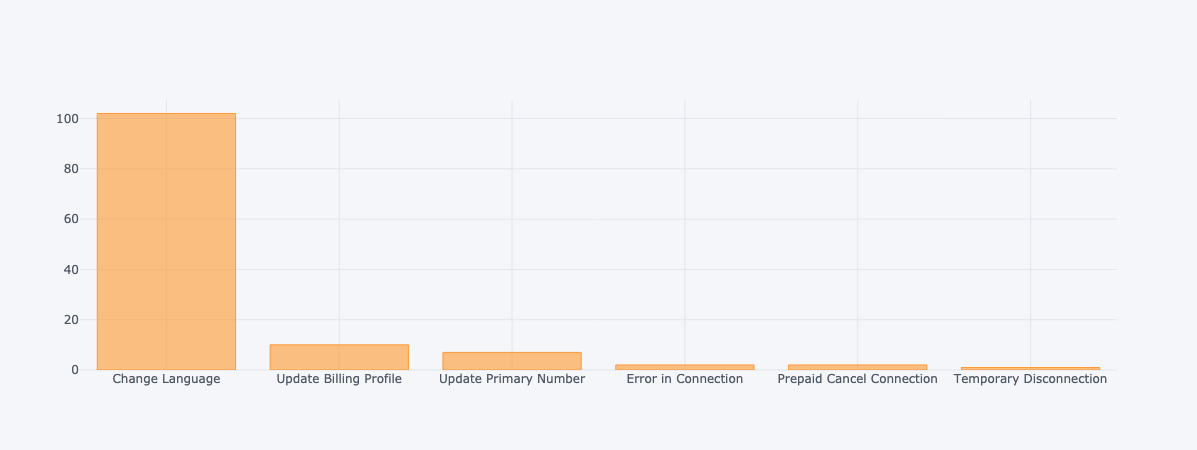

In [42]:
cc_df['CNTCT_AREA_TYP_NME'].value_counts().iplot(kind='bar')

From the previous Graph we can see that there are two requests of cancelation.

In [43]:
cancelation_ids = cc_df['Subscriber_ID'].loc[cc_df.CNTCT_AREA_TYP_NME == 'Prepaid Cancel Connection']
cancelation_ids

4     676
36    677
Name: Subscriber_ID, dtype: int64

let's check their general data and last uses

In [44]:
base_df[:].loc[base_df.Subscriber_ID.isin(list(cancelation_ids))]

Subscriber_ID GENDER_TYPE_CD   BIRTH_DT LINE_SUBSCRIPTION_DATE  \
754            676           MALE  28-Jun-76               6-Apr-19   
832            677           MALE  28-Jun-76               6-Apr-19   

     LAST_USAGE_DATE  LAST_CALL_DATE  LAST_CALL_DATE_ONNET  \
754               19              19                  21.0   
832               19              19                  21.0   

     LAST_CALL_DATE_OFFNET  LAST_CALL_DATE_INT  LAST_SMS_DATE  ...  \
754                   19.0                 NaN          166.0  ...   
832                   19.0                 NaN          166.0  ...   

     PP_LAST_SMS_DATE_ONNET  PP_LAST_SMS_DATE_OFFNET  PP_LAST_DATA_DATE  \
754                     NaN                      NaN               21.0   
832                     NaN                      NaN               21.0   

     PP_LAST_DATA_DATE_PG  PP_LAST_DATA_DATE_SB  PP_ACTIVATION_DATE  \
754                  21.0                  19.0            6-Apr-19   
832                  21.0                  19.0            6-Apr-19   

     PP_REVENUE_LAST_1MON  PP_REVENUE_LAST_3MON    ARPU     BRAND_MODEL  
754                198.58                 665.0  360.95  Apple iPhone 7  
832                198.58                 665.0  360.95  Apple iPhone 7  

[2 rows x 63 columns]

So, it seems like it's two men, or one man with multisim, in his mid 40s, with ARPU of 360.95, with an Apple iPhone 7, let's check if he had any complaints

In [45]:
cc_df.loc[cc_df.Subscriber_ID.isin(list(cancelation_ids))]

Subscriber_ID CNTCT_EVNT_TM CNTCT_AREA_NME         CNTCT_AREA_TYP_NME  \
4             676      01:38:38        Service  Prepaid Cancel Connection   
36            677      01:38:38        Service  Prepaid Cancel Connection   

   CNTCT_EVNT_TYP_CD EXP_CLOSE_DT EXP_CLOSE_TM        EVNT_STRT_DTTM  \
4                  R  08-Apr-2019     07:00:00  01-Apr-2019 01:38:38   
36                 R  08-Apr-2019     07:00:00  01-Apr-2019 01:38:38   

           EVNT_END_DTTM CNTCT_TIER_CD CNTCT_CLSFCTON_CD     DUR  COMMIT_DUR  
4   05-Apr-2019 05:39:18        Tier 2         Technical  100.02       168.0  
36  05-Apr-2019 05:39:18        Tier 2         Technical  100.02       168.0

Well, not much can be seen here.

#### Involuntary Churn

The metrics goes as follows:
- Classify chruning case based on usage
    - Case 1: Last usage is within 15 days
    - Case 2: Last usage was between 16-30 days
    - Case 3: Last usage was 31 days or more
- Classify based on revenue per X Months
    - No Revenue generated mapped with usage.

In [46]:
base_df['churn_case'] = base_df['LAST_USAGE_DATE'].apply(threshold)

In [47]:
case_1_ids = base_df['Subscriber_ID'].loc[base_df['churn_case'] == 1]
case_1_ids

0      273
2      325
5      771
6      451
8      989
9      360
10     463
11     421
12     785
14     991
17      72
19     490
21     787
23     481
24     389
26     220
28     720
29     789
30     278
32     551
33     146
34     951
35     339
37      81
41     798
44     831
47     636
50      34
51     934
53     638
      ... 
942    346
943    288
945    897
946    441
951    643
952    769
954    923
955    399
956    208
957    511
959    172
960    205
962    403
963    970
967    113
971    466
974    532
975    641
978    775
979    496
980    683
981    373
984    315
985    153
989    906
990    633
993    980
994    780
995    820
997    696
Name: Subscriber_ID, Length: 443, dtype: int64

In [48]:
case_2_ids = base_df['Subscriber_ID'].loc[base_df['churn_case'] == 2]
case_2_ids

1      983
13     826
16     558
20     543
31     807
39     853
42     886
48     852
55     381
59     730
70     621
72     953
85     573
93     611
102    368
105      5
106    737
116    857
117    869
121    872
124     36
125    858
139    892
141    280
143     35
144    556
164    824
166    718
168    612
178    579
      ... 
831    132
832    677
844    738
848     46
853    719
855    409
858    109
862    825
863      1
874    689
877    149
885    541
889    410
898    128
901    540
912    119
916    174
920     96
924    380
925    184
931    782
935    580
937    517
944    515
947    998
964    115
969    225
972    729
973    382
992    599
Name: Subscriber_ID, Length: 174, dtype: int64

In [49]:
case_3_ids = base_df['Subscriber_ID'].loc[base_df['churn_case'] == 3]
case_3_ids

3      460
4      319
7      979
15     702
18     890
22     972
25     845
27     741
36     942
38     407
40     237
43     100
45      97
46     627
49     966
52     665
54     445
58     590
67     987
69     663
71     585
74     995
75     913
76     670
79     752
90      63
91     275
99     666
107    745
108    895
      ... 
904    233
918    485
922     79
926     52
927    597
928    311
930    317
934    199
936    218
948    661
949     24
950    498
953    165
958     10
961    536
965    910
966    521
968    940
970    103
976    187
977    336
982    107
983    290
986    332
987    847
988    537
991    412
996    601
998    736
999    130
Name: Subscriber_ID, Length: 383, dtype: int64

Now Let's get the people who stopped paying

In [50]:
no_rev_ids = base_df.Subscriber_ID.loc[(base_df.PP_REVENUE_LAST_3MON == 0) & (base_df.PP_REVENUE_LAST_1MON == 0)]
no_rev_ids

3      460
18     890
22     972
25     845
27     741
36     942
40     237
43     100
45      97
46     627
49     966
52     665
54     445
67     987
74     995
75     913
76     670
79     752
99     666
103    672
107    745
108    895
109    247
110    876
113     51
114    309
116    857
119    883
120    277
125    858
      ... 
870    126
871    616
879    687
882     41
884    105
888    846
890    224
897    131
903    305
904    233
918    485
926     52
928    311
930    317
934    199
948    661
949     24
950    498
953    165
958     10
961    536
970    103
976    187
977    336
983    290
986    332
987    847
988    537
998    736
999    130
Name: Subscriber_ID, Length: 265, dtype: int64

Now let's get cross reference the two conditions together in order to get the most expected users to become churners.

In [51]:
stopped_paying_using_ids = set(no_rev_ids).intersection(case_3_ids)

In [52]:
#Fixing Future birth dates
base_df['BIRTH_DT'] = pd.to_datetime(base_df['BIRTH_DT'].str[:-2] + '19' + base_df['BIRTH_DT'].str[-2:])

In [53]:
churners = base_df.loc[base_df.Subscriber_ID.isin(list(stopped_paying_using_ids))]
churners.head()

Subscriber_ID GENDER_TYPE_CD   BIRTH_DT LINE_SUBSCRIPTION_DATE  \
3             460           MALE 1979-01-05               4-Mar-17   
18            890           MALE 1985-10-23              18-Jan-18   
22            972           MALE 1994-06-23              22-Jul-17   
25            845           MALE 1969-09-12              30-Dec-13   
27            741           MALE 1978-01-29              20-Sep-17   

    LAST_USAGE_DATE  LAST_CALL_DATE  LAST_CALL_DATE_ONNET  \
3               191             200                 200.0   
18              432             432                 432.0   
22              262             307                 307.0   
25               73              73                  73.0   
27              179             179                 247.0   

    LAST_CALL_DATE_OFFNET  LAST_CALL_DATE_INT  LAST_SMS_DATE  ...  \
3                  1173.0               561.0          191.0  ...   
18                  436.0               439.0          433.0  ...   
22                  608.0              1380.0          589.0  ...   
25                  171.0              1725.0          137.0  ...   
27                  267.0               179.0          190.0  ...   

    PP_LAST_SMS_DATE_OFFNET  PP_LAST_DATA_DATE  PP_LAST_DATA_DATE_PG  \
3                       NaN              199.0                 199.0   
18                    450.0                NaN                   NaN   
22                      NaN              265.0                 265.0   
25                    675.0              309.0                 309.0   
27                      NaN              223.0                 249.0   

    PP_LAST_DATA_DATE_SB  PP_ACTIVATION_DATE  PP_REVENUE_LAST_1MON  \
3                  305.0            5-Mar-17                   0.0   
18                 432.0           18-Jan-18                   0.0   
22                 541.0           22-Jul-17                   0.0   
25                 149.0           31-Dec-13                   0.0   
27                 223.0           20-Sep-17                   0.0   

    PP_REVENUE_LAST_3MON    ARPU                               BRAND_MODEL  \
3                    0.0   15.51    Samsung SM-A710 Galaxy A7 LTE Dual Sim   
18                   0.0  368.52  Samsung SM-G532 Galaxy J2 Prime Dual Sim   
22                   0.0    9.82                   Sony Xperia L1 Dual Sim   
25                   0.0    0.00                       Apple iPhone 8 Plus   
27                   0.0   45.10                        Nokia 130 Dual SIM   

    churn_case  
3            3  
18           3  
22           3  
25           3  
27           3  

[5 rows x 64 columns]

Now let's check these out

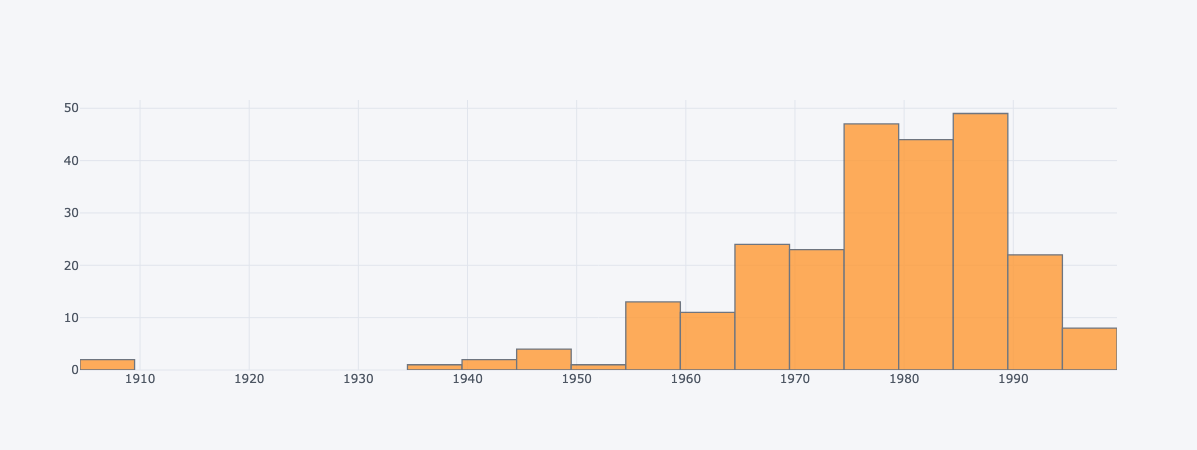

In [56]:
churners.BIRTH_DT.dt.year.iplot(kind='hist')

Most potential churners are almost in their 20s or older

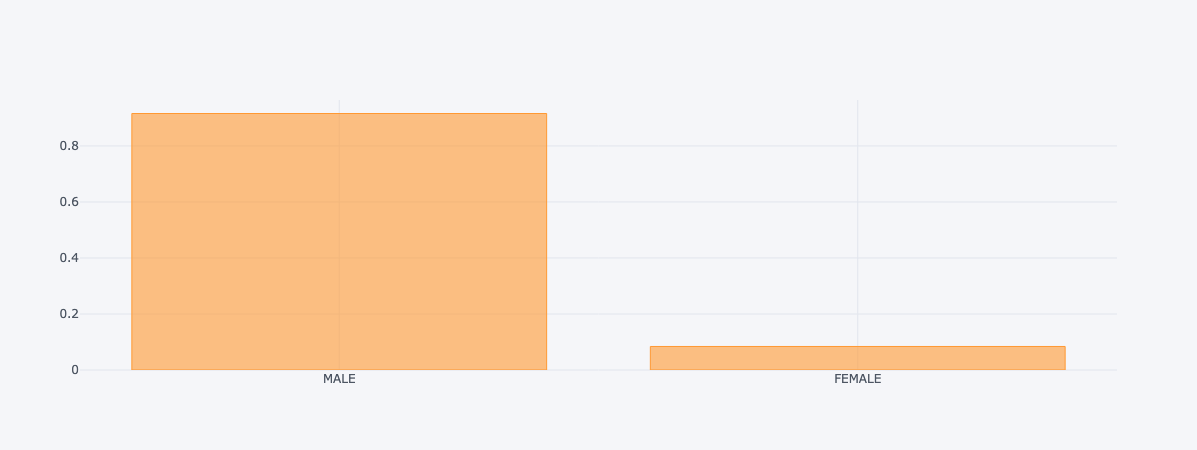

In [62]:
churners.GENDER_TYPE_CD.value_counts('%').iplot(kind='bar')

Majority are Males

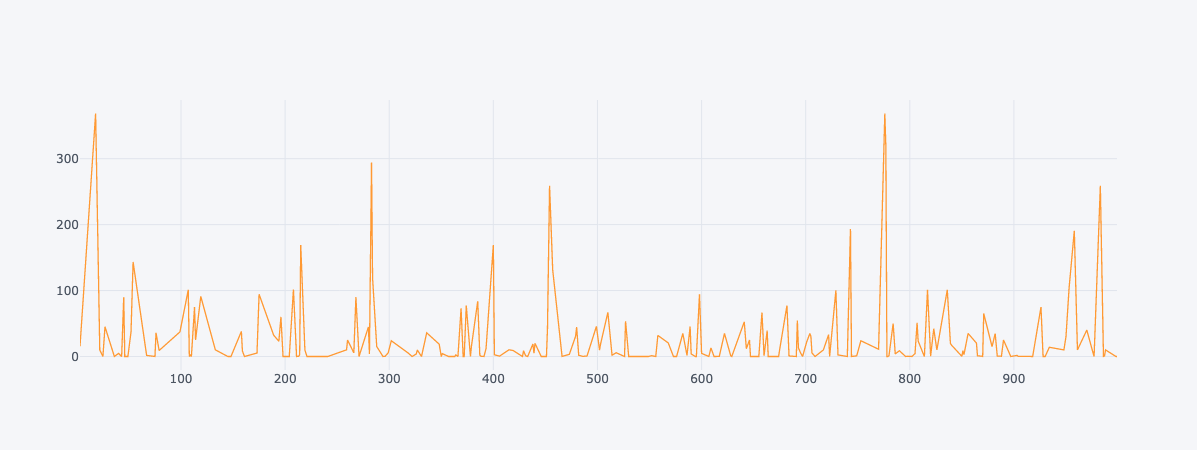

In [64]:
churners.ARPU.iplot(kind='line')

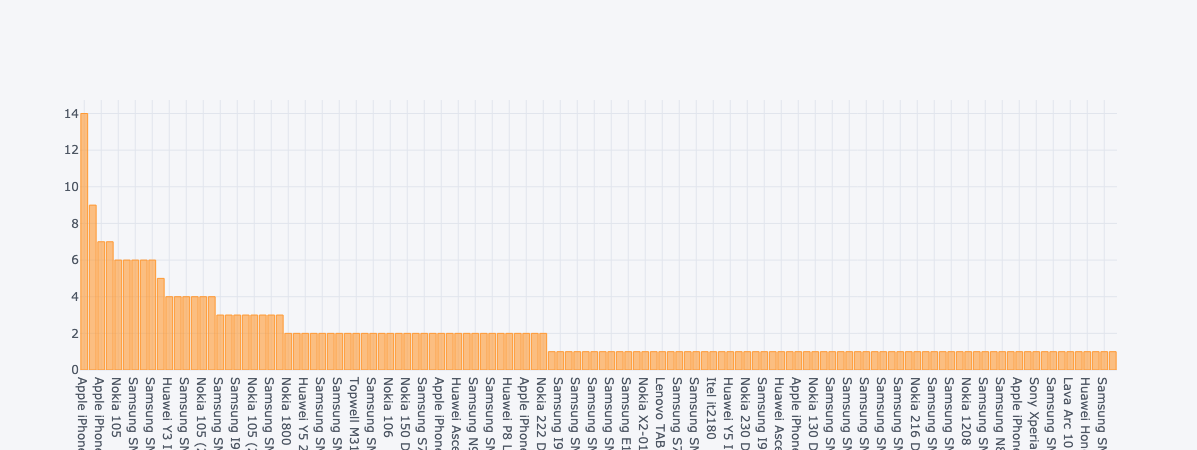

In [65]:
churners.BRAND_MODEL.value_counts().iplot(kind='bar')

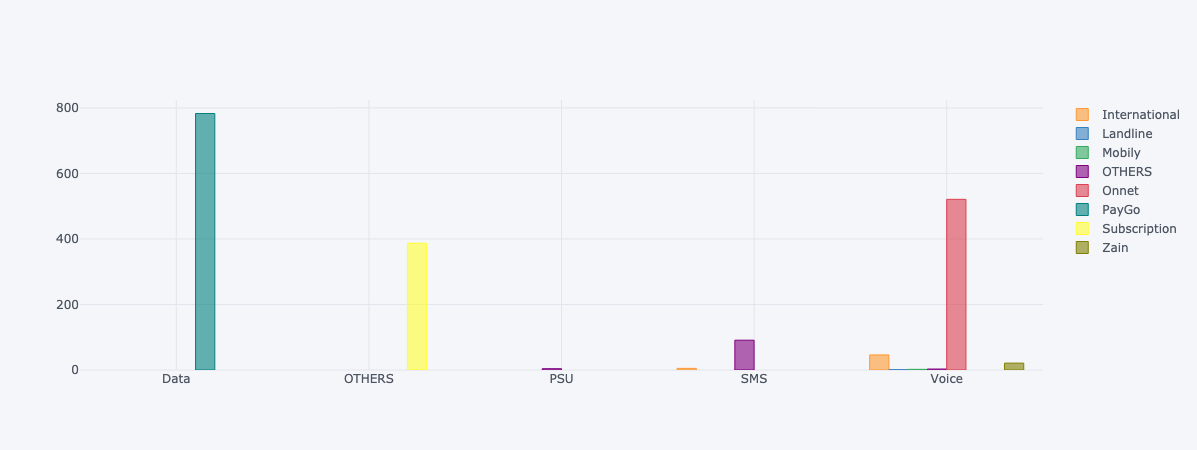

In [72]:
usage_df[usage_df.Subscriber_ID.isin(churners.Subscriber_ID)].groupby('USG_SUB_TYP_NME')['USG_CTGRY_NME'].value_counts().unstack().iplot(kind='bar')

Churners are moslty using their subbscriptions for Data, and Onnet calls, yet we can see a valuable bump when it comes to international calls.

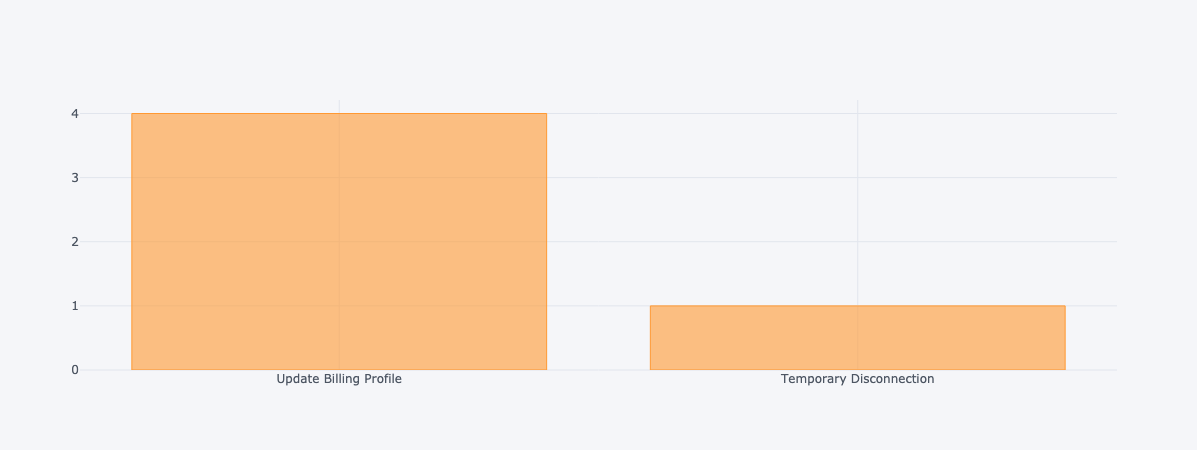

In [74]:
cc_df.loc[cc_df.Subscriber_ID.isin(churners.Subscriber_ID)]['CNTCT_AREA_TYP_NME'].value_counts().iplot(kind='bar')

One thing we can clearly see is that, customers don't complain that much, whether it's a logging issue, or hesitation, that remains to be seen.

In [86]:
sorted(list(churners.LAST_CALL_DATE_INT.loc[churners.LAST_CALL_DATE_INT < 100]), key=lambda x: x, reverse=False)

[96.0]

It doesn't seem like customers are calling internationally a lot

In [94]:
usage_df[(usage_df.Subscriber_ID.isin(churners.Subscriber_ID)) & (usage_df.USG_ROAM_FLG == 'Y')]

TXN_DT  TXN_TME_HOUR  Subscriber_ID USG_CHRGD_FLG USG_SUB_TYP_NME  \
12796  18-Jan-19             7            445             Y             SMS   
13080  18-Jan-19             5            445             Y             SMS   
20497  23-Jan-19            22            734             Y           Voice   
21282  23-Jan-19            17            734             Y           Voice   

       USG_CTGRY_NME USG_ROAM_FLG  TXN_REV_AMT  TXN_REV_ACTL_AMT  TXN_CNT  \
12796  International            Y        2.000             2.000        1   
13080  International            Y        2.000             2.000        1   
20497           Zain            Y        5.252             5.252        1   
21282  International            Y        4.000             4.000        2   

       TXN_DUR  INC_DATA_VOL  OUT_DATA_VOL  
12796        0             1             0  
13080        0             1             0  
20497      182             0             0  
21282       37             0             0

It doesn't seem like users are impacted heavily by roaming, apart from user 20497, and user 21282

Let's investigate the Data in general to get general trends for prepaid users

##### General statistics around the deactivation date

In [42]:
base_df.columns

Index(['Subscriber_ID', 'GENDER_TYPE_CD', 'BIRTH_DT', 'LINE_SUBSCRIPTION_DATE',
       'LAST_USAGE_DATE', 'LAST_CALL_DATE', 'LAST_CALL_DATE_ONNET',
       'LAST_CALL_DATE_OFFNET', 'LAST_CALL_DATE_INT', 'LAST_SMS_DATE',
       'LAST_SMS_DATE_ONNET', 'LAST_SMS_DATE_OFFNET', 'LAST_SMS_DATE_INT',
       'LAST_DATA_DATE', 'LAST_RECHARGE_DATE', 'LAST_RECHARGE_DATE_10SAR',
       'LAST_RECHARGE_DATE_20SAR', 'LAST_RECHARGE_DATE_50SAR',
       'LAST_RECHARGE_DATE_100SAR', 'LAST_RECHARGE_DATE_300SAR',
       'LAST_RECHARGE_DATE_OTHER', 'RECHARGE_AMOUNT_6MON',
       'ACTUAL_RECHARGE_AMOUNT_6MON', 'FIRST_IVR_CALL_DONE_FLAG',
       'FIRST_CALL_DONE_FLAG', 'LANGUAGE_ID', 'SERVICE_FEE_EXPIRY_DATE',
       'SUPERVISION_PERIOD_EXP_DATE', 'ACCOUNT_DISCONNECTION_DATE',
       'SDP_FILE_DATE_N', 'PP_FIRST_USAGE_DATE', 'PP_FIRST_ROAMING_DATE',
       'PP_FIRST_NEGATIVE_BALANCE_DATE', 'PP_FIRST_CALL_DATE',
       'PP_FIRST_CALL_DATE_INT', 'PP_FIRST_CALL_DATE_ONNET',
       'PP_FIRST_CALL_DATE_OFFNET', 'PP

In [43]:
base_df['SERVICE_FEE_EXPIRY_DATE'].value_counts()

27-Aug-19    148
28-Jan-19     69
29-Jan-19     62
30-Jul-19     48
25-Aug-19     31
24-Aug-19     30
26-Aug-19     29
26-Mar-19     28
1-Aug-19      27
31-Jul-19     26
2-Aug-19      25
20-Aug-19     21
21-Aug-19     20
27-Mar-19     19
29-Jul-19     18
17-Aug-19     17
23-Aug-19     13
26-Jul-19     13
9-Aug-19      13
22-Aug-19     12
28-Mar-19     11
1-Feb-19      11
7-Jul-19      11
3-Aug-19      10
13-Aug-19     10
18-Jul-19      9
20-Jul-19      9
4-Jun-19       8
14-Aug-19      8
25-Jul-19      8
            ... 
24-May-19      1
15-Jun-19      1
16-Apr-19      1
6-Apr-19       1
5-Jul-19       1
10-May-19      1
4-Apr-19       1
30-Mar-19      1
1-Jun-19       1
22-May-19      1
8-Apr-19       1
31-Mar-19      1
20-May-19      1
6-Jun-19       1
27-Feb-19      1
3-Jun-19       1
17-Jun-19      1
29-Jun-19      1
20-Jun-19      1
28-Apr-19      1
20-Apr-19      1
21-May-19      1
28-Jun-19      1
19-May-19      1
8-Jun-19       1
25-May-19      1
29-Mar-19      1
26-May-19     

In [44]:
base_df['ACCOUNT_DISCONNECTION_DATE'] = pd.to_datetime(base_df.ACCOUNT_DISCONNECTION_DATE)

In [45]:
base_df.ACCOUNT_DISCONNECTION_DATE.value_counts().sort_index()

2019-09-25     69
2019-09-26     62
2019-09-28      6
2019-09-29     11
2019-10-25      1
2019-11-21     28
2019-11-22     19
2019-11-23     11
2019-11-24      1
2019-11-25      1
2019-11-26      1
2019-11-30      1
2019-12-02      1
2019-12-04      1
2019-12-05      2
2019-12-08      2
2019-12-09      4
2019-12-10      2
2019-12-12      1
2019-12-13      3
2019-12-16      1
2019-12-17      2
2019-12-18      2
2019-12-21      7
2019-12-22      3
2019-12-24      1
2019-12-26      1
2019-12-28      3
2019-12-29      2
2020-01-05      1
             ... 
2020-03-25     18
2020-03-26     48
2020-03-27     26
2020-03-28     27
2020-03-29     25
2020-03-30     10
2020-03-31      2
2020-04-01      5
2020-04-02      7
2020-04-03      8
2020-04-04      2
2020-04-05     13
2020-04-06      6
2020-04-07      4
2020-04-08      5
2020-04-09     10
2020-04-10      8
2020-04-11      4
2020-04-12      5
2020-04-13     17
2020-04-14      3
2020-04-15      5
2020-04-16     21
2020-04-17     20
2020-04-18

###### Demographical Features (Age and stuff)

In [46]:
base_df['BIRTH_DT'] = pd.to_datetime(base_df['BIRTH_DT'].str[:-2] + '19' + base_df['BIRTH_DT'].str[-2:])

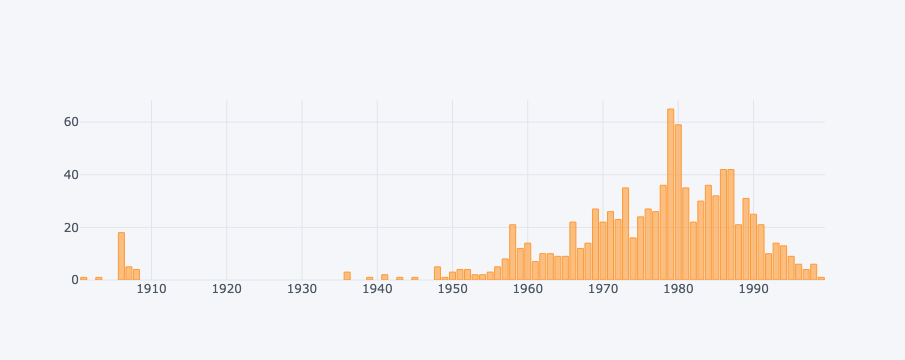

In [58]:
#visualize overoall subscribers birth year
base_df.BIRTH_DT.dt.year.value_counts().iplot(kind='bar')

In [58]:
base_df['BIRTH_YR'] = base_df.BIRTH_DT.dt.year

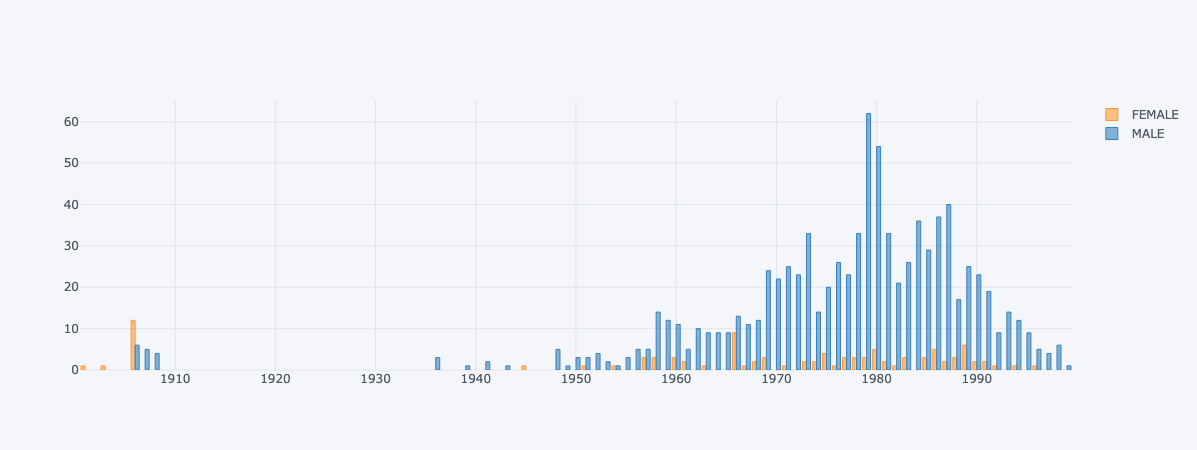

In [59]:
#the relation btw gender and birth date
base_df.groupby('BIRTH_YR')['GENDER_TYPE_CD'].value_counts().unstack().iplot(kind='bar')

Most churners were born in 1979 and males.

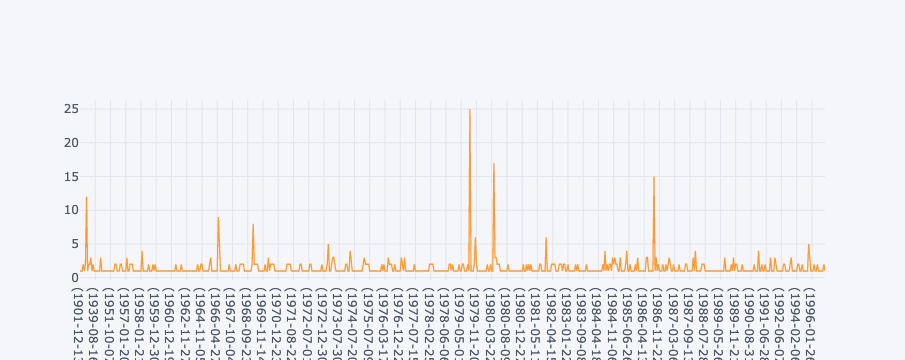

In [61]:
#classify based on birth date and revenue
base_df.groupby('BIRTH_DT')["ARPU"].value_counts().iplot()

Most revenue comes from subscribers of 1979 birth year while they're the majority of the data set. This leads to inaccuray of the assumption.

In [62]:
# create AGE column
from datetime import datetime
base_df['AGE'] = (datetime.now() - base_df['BIRTH_DT']) 
base_df['AGE'] = base_df['AGE'] /  np.timedelta64(1, 'Y')

In [63]:
base_df['month'] = base_df.ACCOUNT_DISCONNECTION_DATE.dt.month

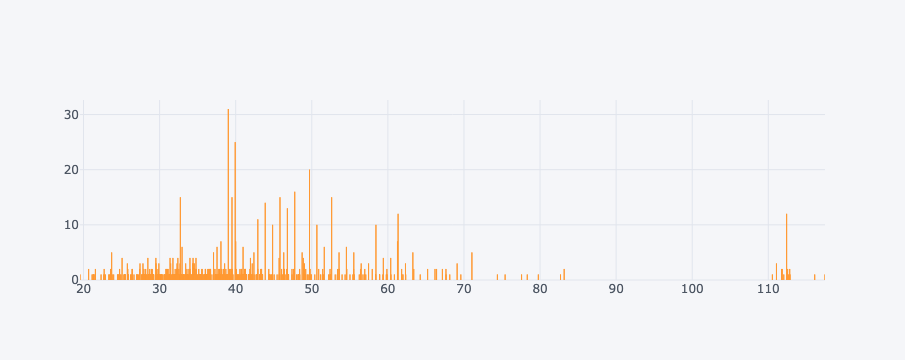

In [64]:
#The range of ages in our dataset
base_df['AGE'].value_counts().iplot(kind='bar')

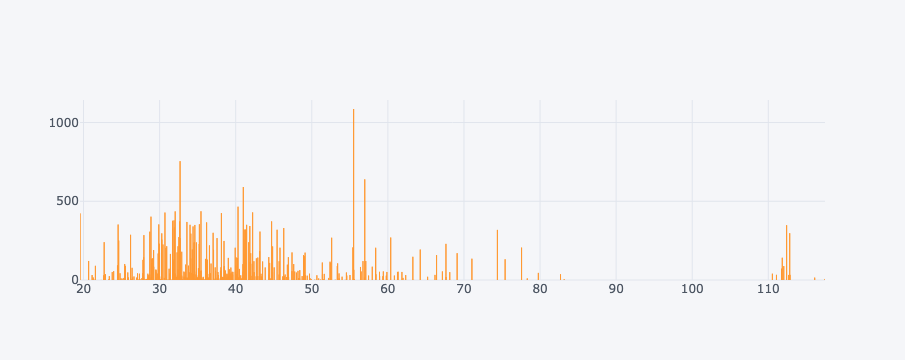

In [65]:
#Classify based on age and revenue
base_df[base_df["AGE"] > 15].groupby('AGE')['ARPU'].agg('mean').iplot(kind='bar')

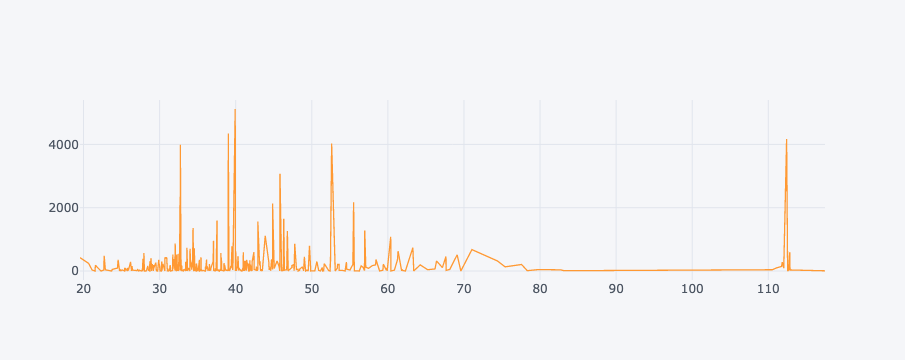

In [66]:
#Classify based on age and revenue
base_df.loc[base_df.AGE > 0].groupby('AGE')['ARPU'].agg('sum').iplot(kind='line')

In the first chart, most Average revenue comes from 19 followd by 74 age. While the second one most revenue comes from age of 39 followed by 32. There are some variance between the 2 charts which indicates some data misleadings. Furthuremore, Some ages range exceed the default exceed the life span which indicated inaccurate data or some faulty.

##### Service Suspension

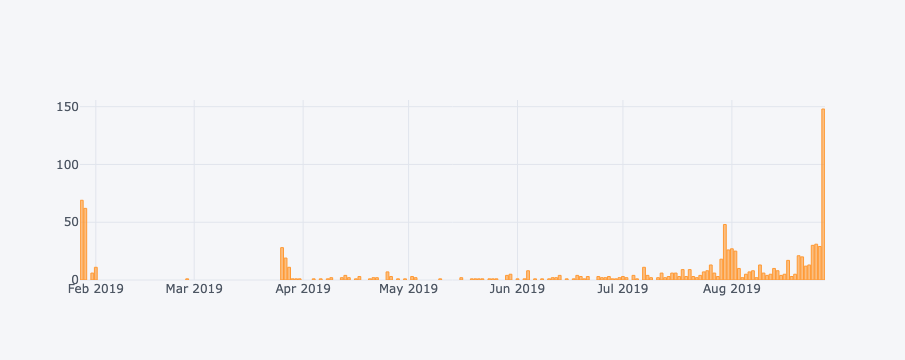

In [67]:
base_df.SERVICE_FEE_EXPIRY_DATE.value_counts().iplot(kind='bar')

In [68]:
base_df['SERVICE_FEE_EXPIRY_DATE'] = pd.to_datetime(base_df['SERVICE_FEE_EXPIRY_DATE'])

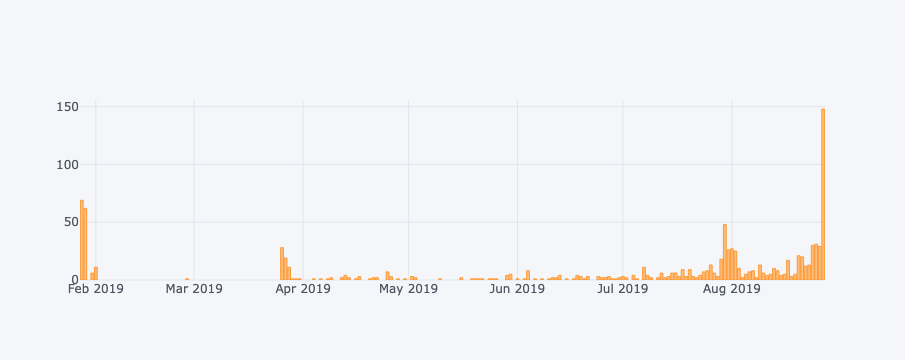

In [69]:
base_df['SERVICE_FEE_EXPIRY_DATE'].value_counts().sort_index().iplot(kind='bar')

Most expiry happend in Aug27,2019.

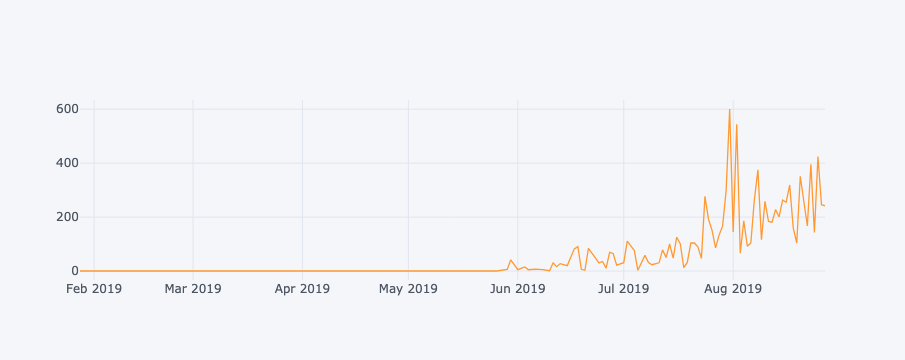

In [70]:
#classify churner baed on revenue last 3 months
base_df.groupby('SERVICE_FEE_EXPIRY_DATE')['PP_REVENUE_LAST_3MON'].agg('mean').iplot(kind='line')

Churners has the highest prepaid revenue are in Jul31,2019 followd by Aug2,2019.

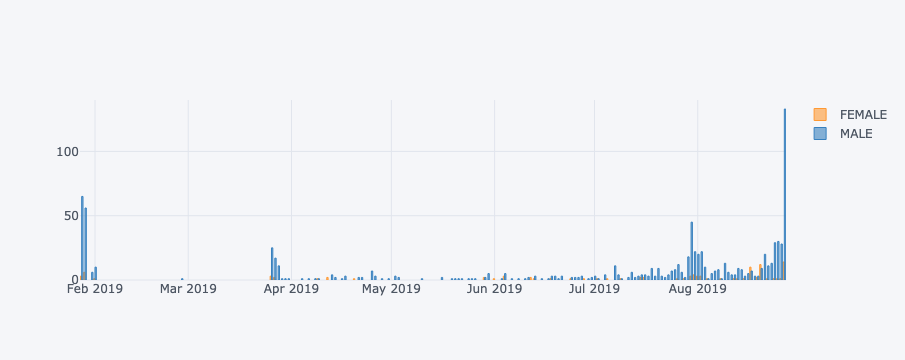

In [71]:
# classify churners based on gender
base_df.groupby('SERVICE_FEE_EXPIRY_DATE')['GENDER_TYPE_CD'].value_counts().unstack().iplot(kind='bar')

Male churn happened in Aug27, 2019 in general. while most of them were male churners. This might be an indication of some event in that date which would help for furthure investigation. 

#### Since data are all of customers who churned (deactivated their accounts), I will try and get the main features and behavior of said customers:

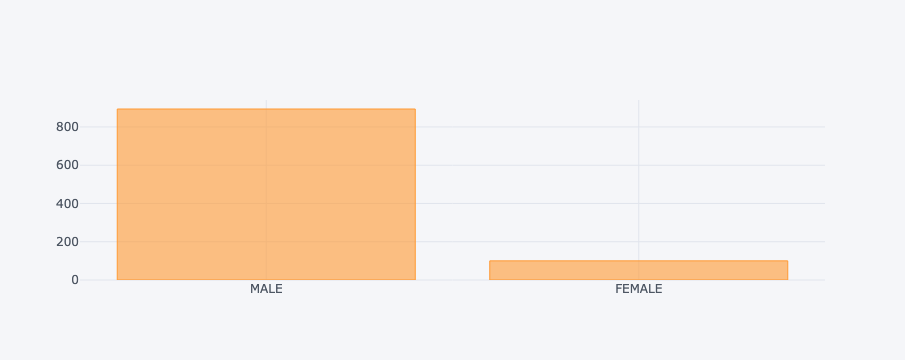

In [72]:
#classify by gender count
base_df.GENDER_TYPE_CD.value_counts().iplot(kind='bar')

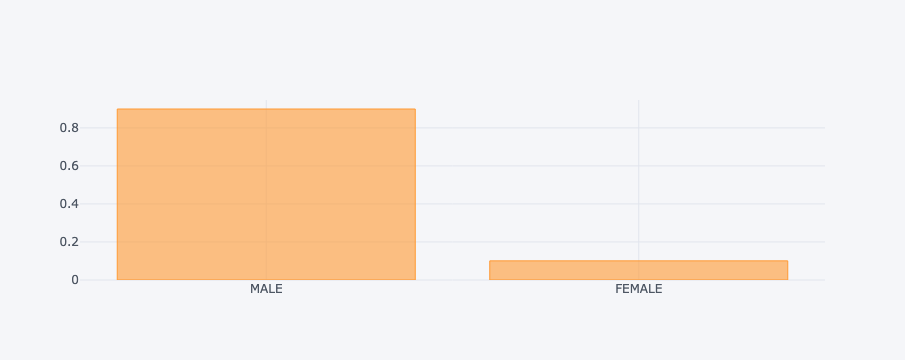

In [73]:
#classify by gender percentages
base_df.GENDER_TYPE_CD.value_counts('%').iplot(kind='bar')

###### Count the number of males and females in our dataset 

We can see that the majority of records, 90%, are males.

###### Count number of deactivation based on years and gender

In [76]:
(base_df.groupby(base_df.ACCOUNT_DISCONNECTION_DATE.dt.year).GENDER_TYPE_CD.value_counts()).unstack()

GENDER_TYPE_CD              FEMALE  MALE
ACCOUNT_DISCONNECTION_DATE              
2019                            19   229
2020                            81   665

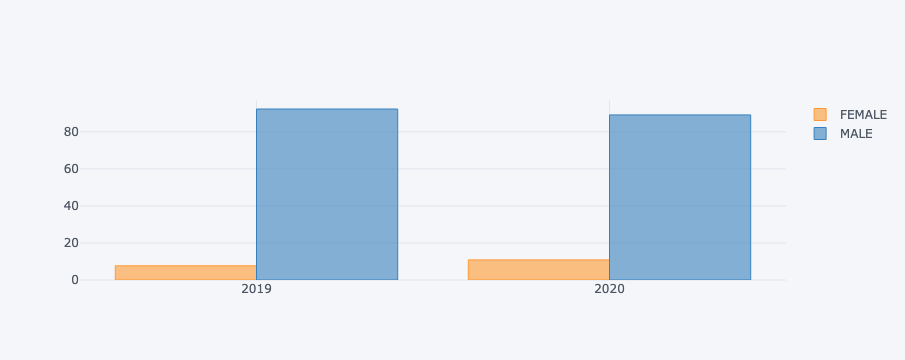

In [77]:
(base_df.groupby(base_df.ACCOUNT_DISCONNECTION_DATE.dt.year).GENDER_TYPE_CD.value_counts('%')*100).unstack().iplot(kind='bar')

Most Churners are Males with almost 90% majority. This indicate that Males are easier to lose than females, where they are much loyal. Furthuremore, the he year of 2020 has almost x4 number of Churners more than 2019. The majority of them are males. Note that the number of male and female are alomost identical.

##### Relation between gender and revenue

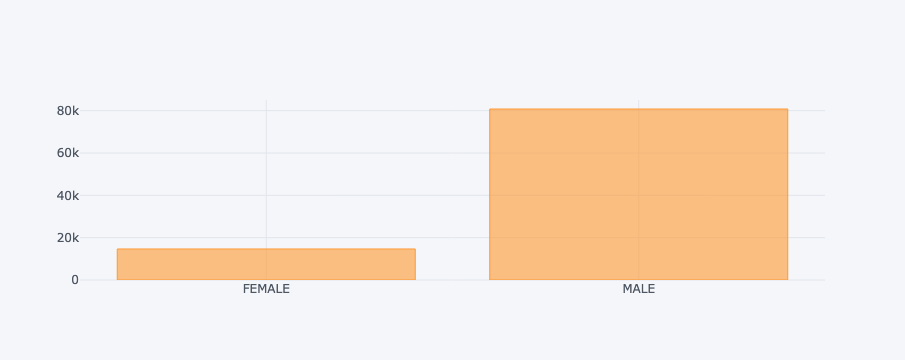

In [78]:
#classify based on gender and revene
base_df.groupby('GENDER_TYPE_CD')['ARPU'].agg('sum').iplot(kind='bar')

ARPU for Churned males exceeds 80K SAR, while Females are around 14.4K SAR

##### Different features of deactivation

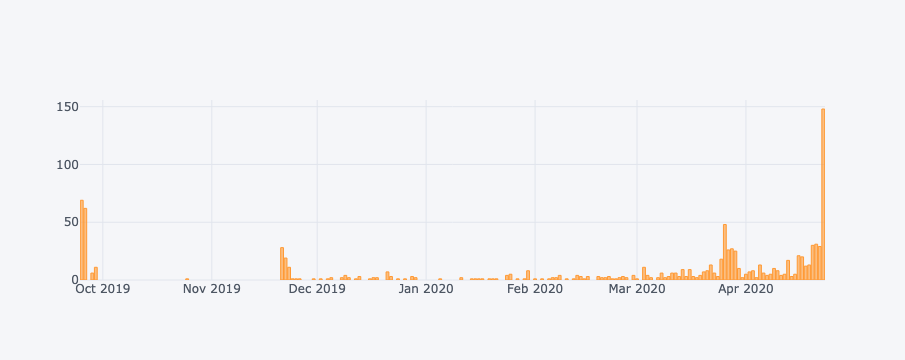

In [79]:
#classify by disconnection date
base_df.ACCOUNT_DISCONNECTION_DATE.value_counts().iplot(kind='bar')

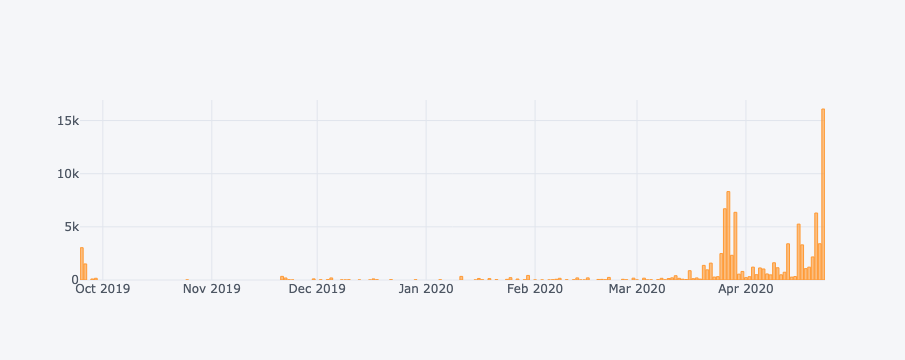

In [80]:
#classify based in disconnection date and revenue
base_df.groupby(['ACCOUNT_DISCONNECTION_DATE'])['ARPU'].agg('sum').iplot(kind='bar')

##### Different relation of usgae

In [61]:
base_df.loc[base_df.PP_REVENUE_LAST_3MON < 10].mean()

Subscriber_ID                    499.379518
LAST_USAGE_DATE                  284.710843
LAST_CALL_DATE                   324.641566
LAST_CALL_DATE_ONNET             339.281818
LAST_CALL_DATE_OFFNET            500.146875
LAST_CALL_DATE_INT               740.923954
LAST_SMS_DATE                    395.455108
LAST_SMS_DATE_ONNET              594.993506
LAST_SMS_DATE_OFFNET             702.100877
LAST_SMS_DATE_INT                632.029167
LAST_DATA_DATE                   506.405498
LAST_RECHARGE_DATE               273.708661
LAST_RECHARGE_DATE_10SAR         435.104712
LAST_RECHARGE_DATE_20SAR         330.081871
LAST_RECHARGE_DATE_50SAR         339.188679
LAST_RECHARGE_DATE_100SAR        321.262295
LAST_RECHARGE_DATE_300SAR        362.000000
LAST_RECHARGE_DATE_OTHER         141.000000
RECHARGE_AMOUNT_6MON              41.113228
ACTUAL_RECHARGE_AMOUNT_6MON       40.570866
FIRST_IVR_CALL_DONE_FLAG           0.367470
FIRST_CALL_DONE_FLAG               0.018072
LANGUAGE_ID                     

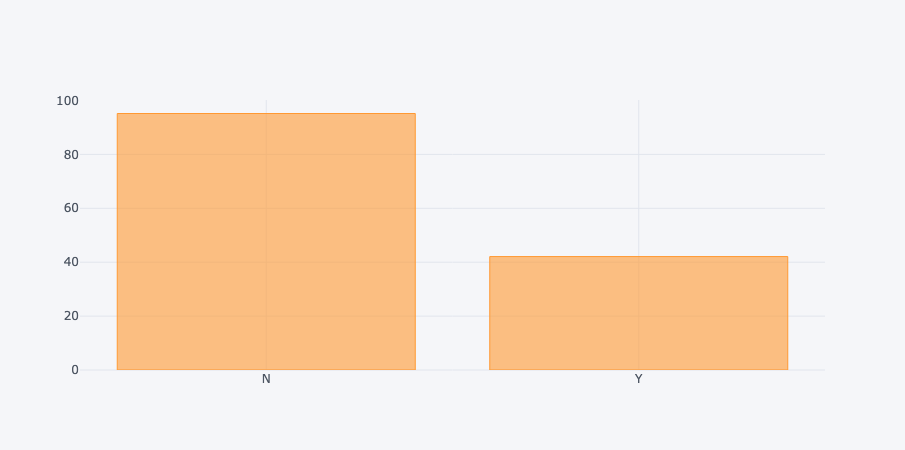

In [68]:
#classify based on roaming and duration consumed the transactions
usage_df.groupby('USG_ROAM_FLG')['TXN_DUR'].mean().iplot(kind='bar')

When there is no roming the duration of transaction are more.

In [69]:
#convert TXN_DT to datatime
usage_df['TXN_DT'] = pd.to_datetime(usage_df.TXN_DT)

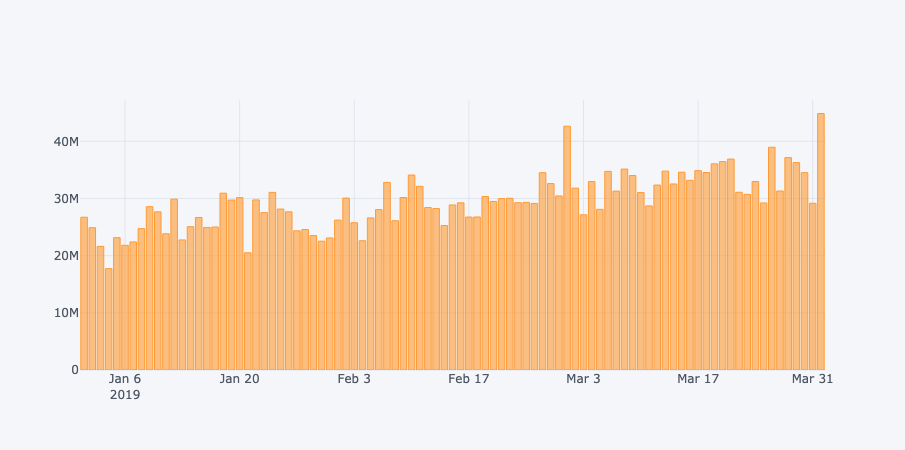

In [70]:
#classify usgae based on incoming data volume for each usage
usage_df.groupby('TXN_DT')['INC_DATA_VOL'].mean().iplot(kind='bar')

The highest esage volumeis in April 1,2019.

In [71]:
#classify subscribers based on their usage
usage_df.groupby('Subscriber_ID')['TXN_DT'].count().mean()

429.88235294117646

The number of subscribers that have a usage volume are 430.

###### Different relations with brand model

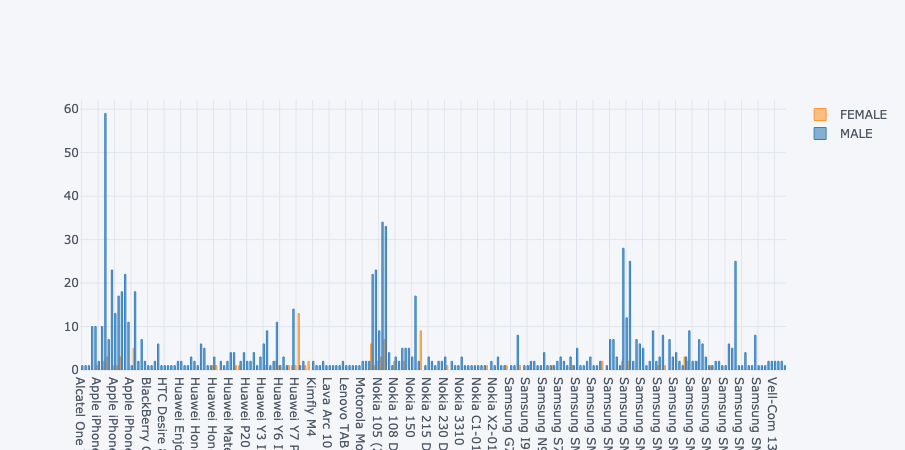

In [76]:
# relation bte brand model and gender
base_df.groupby('BRAND_MODEL')['GENDER_TYPE_CD'].value_counts().unstack().iplot(kind='bar')

Most subscriber own iPhone6 and males.

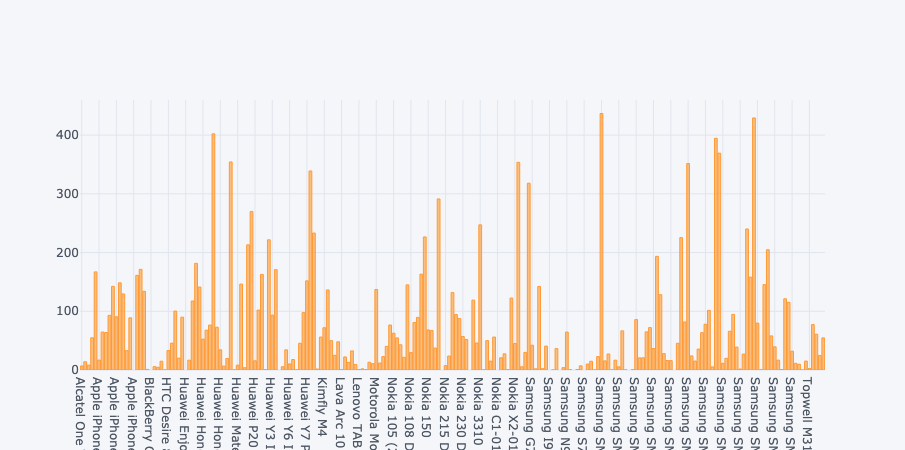

In [77]:
# relation bte brand model and revenue
base_df.groupby('BRAND_MODEL')['ARPU'].agg('mean').iplot(kind='bar')

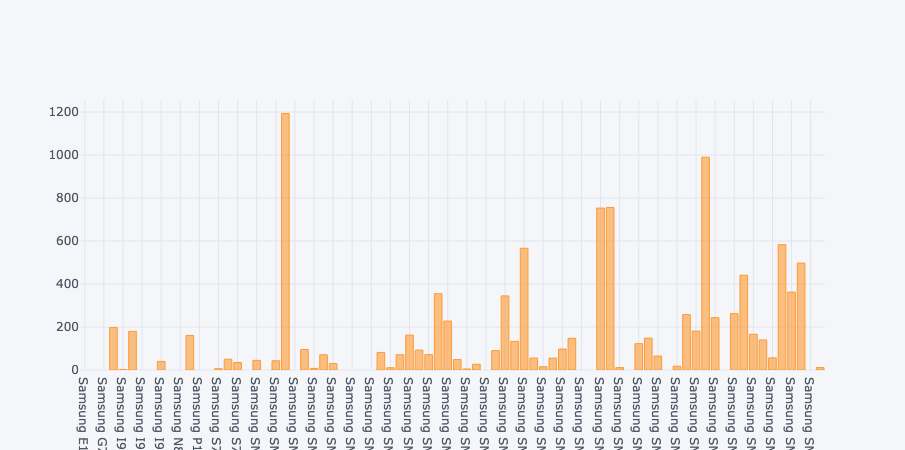

In [78]:
base_df.loc[base_df['BRAND_MODEL'].str.contains('Samsung', na=False)].groupby('BRAND_MODEL')['PP_REVENUE_LAST_3MON'].agg('mean').iplot(kind='bar')

In [120]:
(base_df.groupby(base_df.ACCOUNT_DISCONNECTION_DATE.dt.year).BRAND_MODEL.value_counts('%')*100).unstack()

BRAND_MODEL                 Alcatel One Touch 1054 Dual Sim  \
ACCOUNT_DISCONNECTION_DATE                                    
2019                                                    NaN   
2020                                               0.133333   

BRAND_MODEL                 Alcatel One Touch PIXI First Dual Sim  \
ACCOUNT_DISCONNECTION_DATE                                          
2019                                                     0.404858   
2020                                                          NaN   

BRAND_MODEL                 Apple iPhone 4  Apple iPhone 4S  Apple iPhone 5  \
ACCOUNT_DISCONNECTION_DATE                                                    
2019                              0.404858         2.834008        0.404858   
2020                                   NaN         0.400000        1.200000   

BRAND_MODEL                 Apple iPhone 5C  Apple iPhone 5S  Apple iPhone 6  \
ACCOUNT_DISCONNECTION_DATE                                                     
2019                                    NaN         0.809717        6.477733   
2020                                    0.4         1.066667        6.000000   

BRAND_MODEL                 Apple iPhone 6 Plus  Apple iPhone 6S  ...  \
ACCOUNT_DISCONNECTION_DATE                                        ...   
2019                                   0.809717         0.809717  ...   
2020                                   1.066667         2.800000  ...   

BRAND_MODEL                 Samsung SM-T285 Galaxy Tab A 7.0 LTE  \
ACCOUNT_DISCONNECTION_DATE                                         
2019                                                    0.404858   
2020                                                         NaN   

BRAND_MODEL                 Samsung SM-T531 Galaxy Tab 4 10.1  \
ACCOUNT_DISCONNECTION_DATE                                      
2019                                                      NaN   
2020                                                 0.133333   

BRAND_MODEL                 Sony Xperia L1 Dual Sim  Source J-MAX-Gladitor  \
ACCOUNT_DISCONNECTION_DATE                                                   
2019                                       0.404858               0.404858   
2020                                            NaN                    NaN   

BRAND_MODEL                 Symphony B17  Topwell M318A  Vell-Com 130  \
ACCOUNT_DISCONNECTION_DATE                                              
2019                                 NaN            NaN      0.809717   
2020                            0.266667       0.266667           NaN   

BRAND_MODEL                 Wiko Slide 2  Winstar W7000  ZELTA FS14  
ACCOUNT_DISCONNECTION_DATE                                           
2019                            0.404858            NaN    0.404858  
2020                            0.133333       0.266667         NaN  

[2 rows x 215 columns]

The brand models that are generating most revenue are Sumsung Galaxy A7, J7m J2 and Huawei Honor 8. while apple iPhone users are more likely to churn more than other phone users.

###### The duration between subscription and recharge

In [80]:
# conver features to datetime
base_df['LAST_RECHARGE_DATE'] = pd.to_datetime(base_df['LAST_RECHARGE_DATE'])
base_df['LINE_SUBSCRIPTION_DATE'] = pd.to_datetime(base_df['LINE_SUBSCRIPTION_DATE'])

In [81]:
# calculate the duration to the last recharge
base_df['DUR_TO_LAST_RECHARGE'] = (base_df['LAST_RECHARGE_DATE'] - base_df['LINE_SUBSCRIPTION_DATE']).dt.days

In [82]:
# calculate the duration from activation to to deactivation
base_df['DUR_TO_DEACTIVATION'] = (base_df.SERVICE_FEE_EXPIRY_DATE - base_df['LINE_SUBSCRIPTION_DATE']).dt.days

In [83]:
# calculate the duration from last recharge to to deactivation
base_df['DUR_FROM_RECHARGE'] = (base_df.SERVICE_FEE_EXPIRY_DATE - base_df['LAST_RECHARGE_DATE']).dt.days

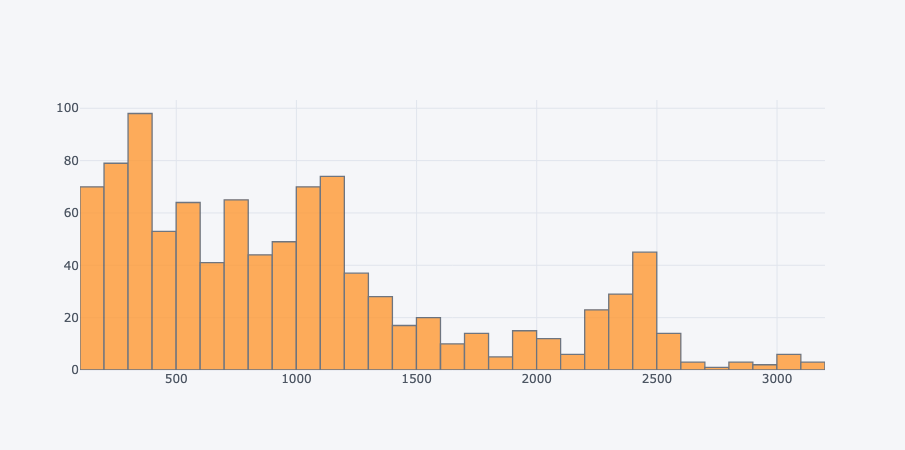

In [84]:
base_df.DUR_TO_DEACTIVATION.iplot(kind='hist')

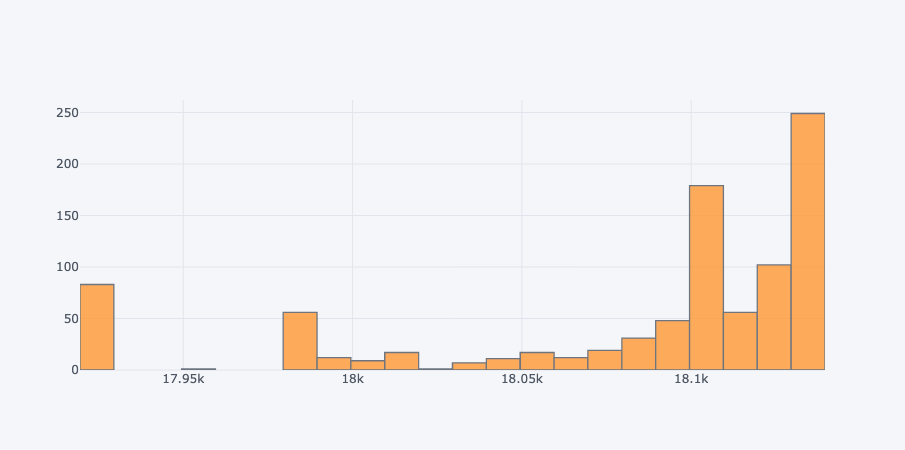

In [85]:
base_df.DUR_FROM_RECHARGE.iplot(kind='hist')

Subscriber's IDs from 300 to 399 has the highest duration from where they subscribe untill they deactivate.

 ##### Relations with tickets 

In [121]:
#How many customers raised a complain ticket
(cc_df.CNTCT_EVNT_TYP_CD=='C').value_counts()

False    122
True       2
Name: CNTCT_EVNT_TYP_CD, dtype: int64

In [122]:
#How many customers raised a request ticket
(cc_df.CNTCT_EVNT_TYP_CD=='R').value_counts()

True     122
False      2
Name: CNTCT_EVNT_TYP_CD, dtype: int64

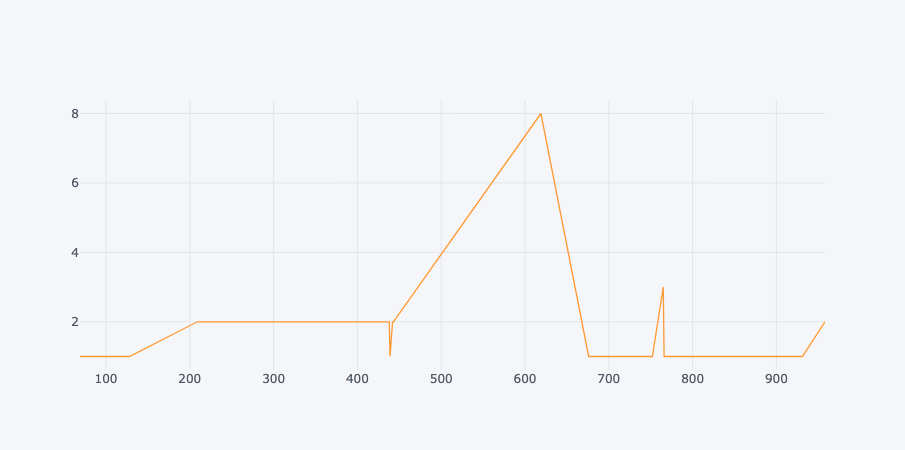

In [129]:
#count how many tiket a subscriber raised
cc_df.Subscriber_ID.value_counts().sort_index().iplot(kind='line');

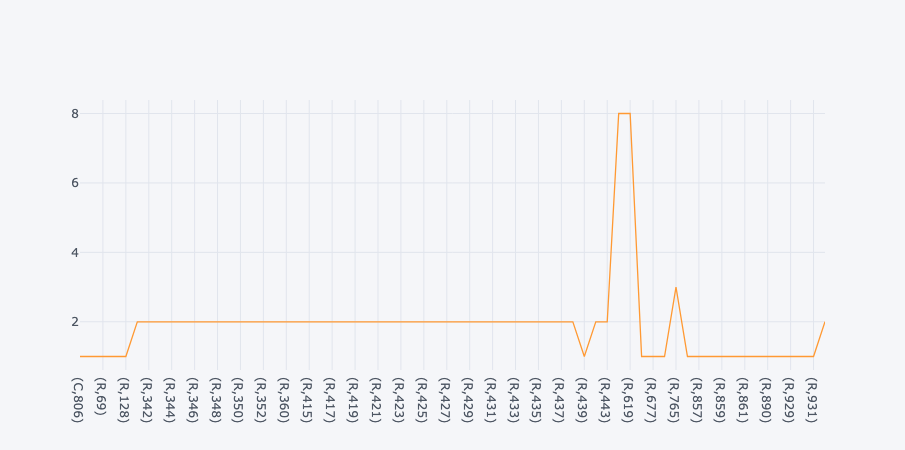

In [130]:
#count the classification of raised tickets: C or R 
cc_df.groupby(cc_df.CNTCT_EVNT_TYP_CD).Subscriber_ID.value_counts().sort_index().iplot(kind='line');

Most subscribers who raised tickets IDs are from 500 to 680

###### Merge Base nad CC Event

In [131]:
df_merge = pd.merge(base_df, cc_df)

In [132]:
# after merge, there are 124 churners raised a ticket
df_merge.Subscriber_ID.nunique()

66

In [133]:
#the whole numer of subscribers are 1000
#base_df.shape
base_df.Subscriber_ID.nunique()

1000

In [134]:
# calculate the percentage of churners that raised a ticket out from the whole number of subscribers
(df_merge.Subscriber_ID.nunique()/base_df.Subscriber_ID.nunique())*100

6.6000000000000005

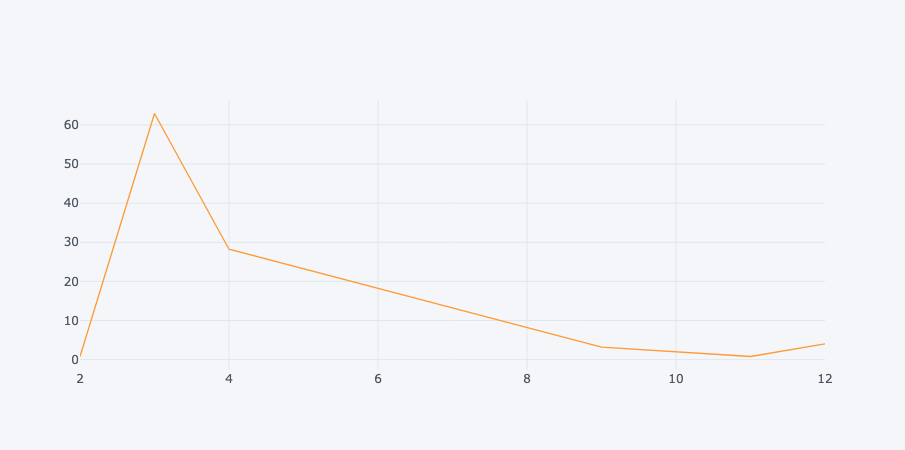

In [136]:
(df_merge.ACCOUNT_DISCONNECTION_DATE.dt.month.value_counts('%')*100).sort_index().iplot(kind='line');

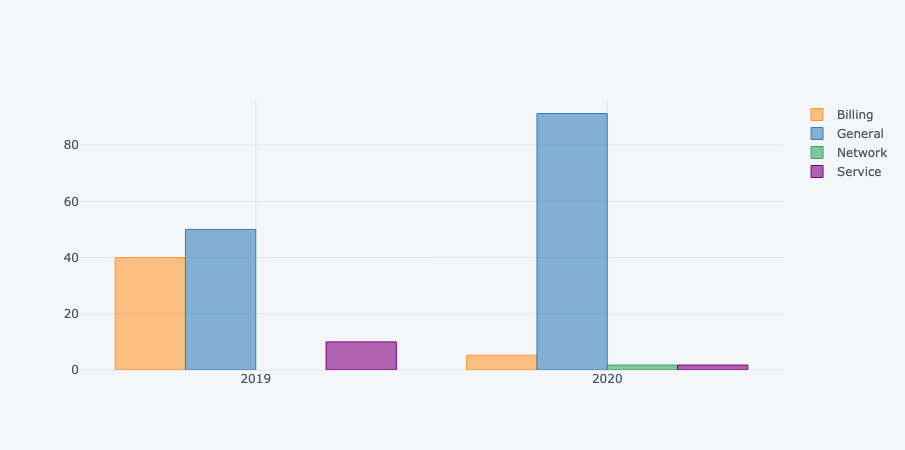

In [138]:
# count the classification of raised tickets
(df_merge.groupby(df_merge.ACCOUNT_DISCONNECTION_DATE.dt.year).CNTCT_AREA_NME.value_counts('%')*100).unstack().iplot(kind='bar');

Most tickets raised are for General issues followed by Billing issues while the number of tickets extremely increases in the year of 2020

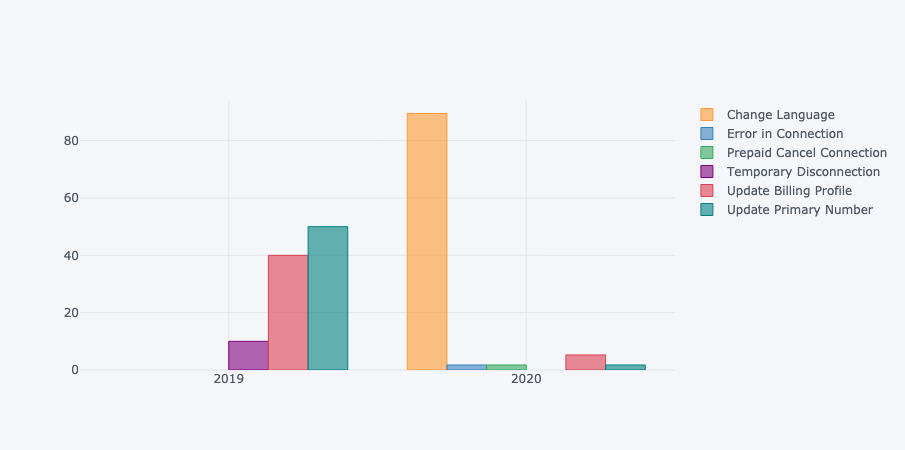

In [140]:
#count the issue area of raised tickets
(df_merge.groupby(df_merge.ACCOUNT_DISCONNECTION_DATE.dt.year).CNTCT_AREA_TYP_NME.value_counts('%')*100).unstack().iplot(kind='bar');

Most tickets raised are for change language followed by update primary number while the number of tickets extremely increases in the year of 2020

## Limitations

> The data seems to be all about unsubscribers and the analysis is purely based on the characteristics of unsubscribers. which will help to indicate their behavior and future prediction. However, the data would be better for decision making if it has both current subscribers and unsubscribers to correlate the variance between them.

> The data look like it has some misleading. For instance, it has deactivation dates based on the future (2020) while there is no justification. This leaves the analysis for assumption, not for decisions. Furthermore, due to many faulty data, data doesn't answer related questions as expected.

> Some other factors would be counted is that difficultly in handling time data with Large scale, while some data are ambiguous.

### Note** Conclusion are made under each part.

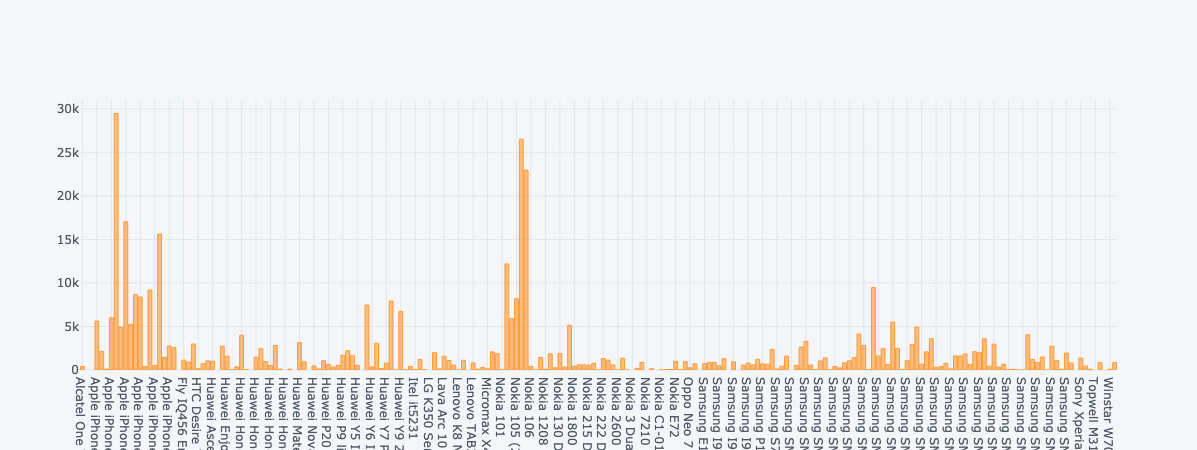

In [83]:
base_df.groupby('BRAND_MODEL')['LAST_CALL_DATE_INT'].sum().iplot(kind='bar')

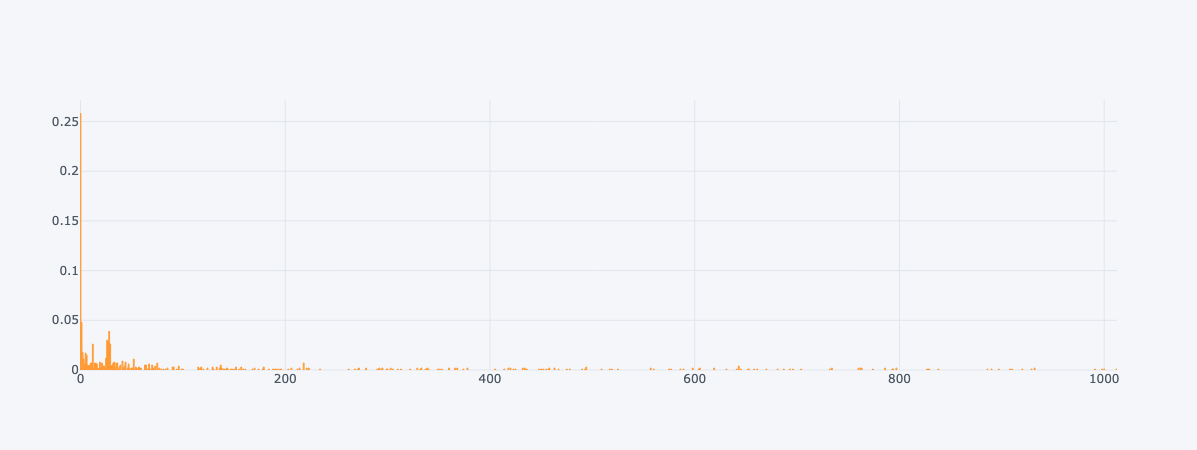

In [88]:
base_df['LAST_USAGE_DATE'].value_counts('%').iplot(kind="bar")

In [90]:
base_df['churn_case'] = base_df['LAST_USAGE_DATE'].apply(threshold)

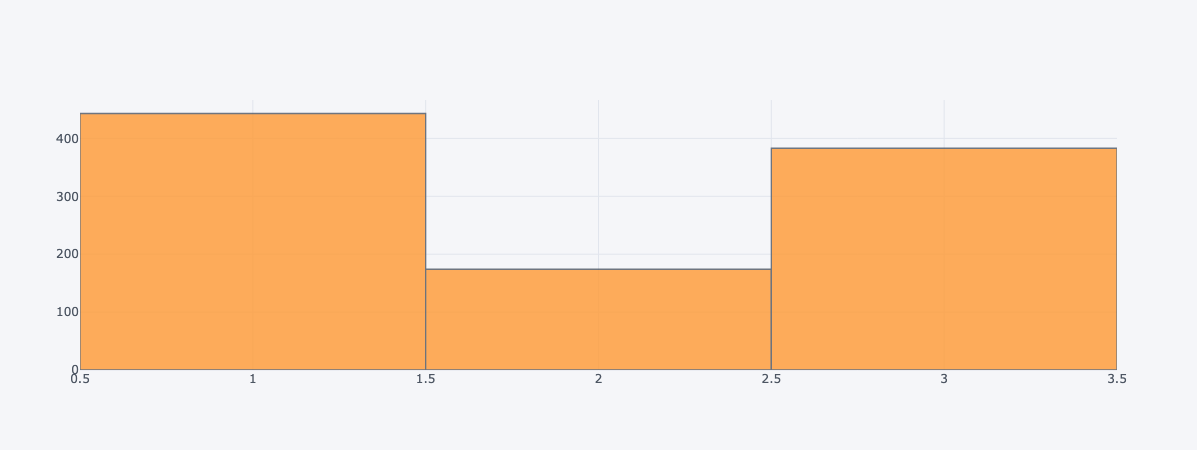

In [96]:
base_df['churn_case'].iplot(kind='hist')

In [107]:
case_1_ids = base_df['Subscriber_ID'].loc[base_df['churn_case'] == 1]

case_1_ids

0      273
2      325
5      771
6      451
8      989
9      360
10     463
11     421
12     785
14     991
17      72
19     490
21     787
23     481
24     389
26     220
28     720
29     789
30     278
32     551
33     146
34     951
35     339
37      81
41     798
44     831
47     636
50      34
51     934
53     638
      ... 
942    346
943    288
945    897
946    441
951    643
952    769
954    923
955    399
956    208
957    511
959    172
960    205
962    403
963    970
967    113
971    466
974    532
975    641
978    775
979    496
980    683
981    373
984    315
985    153
989    906
990    633
993    980
994    780
995    820
997    696
Name: Subscriber_ID, Length: 443, dtype: int64

In [97]:
case_2_ids = base_df['Subscriber_ID'].loc[base_df['churn_case'] == 2]

case_2_ids

1      983
13     826
16     558
20     543
31     807
39     853
42     886
48     852
55     381
59     730
70     621
72     953
85     573
93     611
102    368
105      5
106    737
116    857
117    869
121    872
124     36
125    858
139    892
141    280
143     35
144    556
164    824
166    718
168    612
178    579
      ... 
831    132
832    677
844    738
848     46
853    719
855    409
858    109
862    825
863      1
874    689
877    149
885    541
889    410
898    128
901    540
912    119
916    174
920     96
924    380
925    184
931    782
935    580
937    517
944    515
947    998
964    115
969    225
972    729
973    382
992    599
Name: Subscriber_ID, Length: 174, dtype: int64

In [108]:
case_3_ids = base_df['Subscriber_ID'].loc[base_df['churn_case'] == 3]

case_3_ids

3      460
4      319
7      979
15     702
18     890
22     972
25     845
27     741
36     942
38     407
40     237
43     100
45      97
46     627
49     966
52     665
54     445
58     590
67     987
69     663
71     585
74     995
75     913
76     670
79     752
90      63
91     275
99     666
107    745
108    895
      ... 
904    233
918    485
922     79
926     52
927    597
928    311
930    317
934    199
936    218
948    661
949     24
950    498
953    165
958     10
961    536
965    910
966    521
968    940
970    103
976    187
977    336
982    107
983    290
986    332
987    847
988    537
991    412
996    601
998    736
999    130
Name: Subscriber_ID, Length: 383, dtype: int64

In [98]:
cc_df.head()

Subscriber_ID CNTCT_EVNT_TM CNTCT_AREA_NME         CNTCT_AREA_TYP_NME  \
1            360      16:53:58        General            Change Language   
2            618      18:55:12        General            Change Language   
3            618      10:51:39        General            Change Language   
4            676      01:38:38        Service  Prepaid Cancel Connection   
5            752      05:50:16        Service    Temporary Disconnection   

  CNTCT_EVNT_TYP_CD EXP_CLOSE_DT EXP_CLOSE_TM        EVNT_STRT_DTTM  \
1                 R  25-Feb-2019     16:53:58  24-Feb-2019 16:53:58   
2                 R  15-Jan-2019     18:55:12  14-Jan-2019 18:55:12   
3                 R  06-Jan-2019     10:51:39  05-Jan-2019 10:51:39   
4                 R  08-Apr-2019     07:00:00  01-Apr-2019 01:38:38   
5                 R  02-Apr-2019     07:00:00  01-Apr-2019 05:50:16   

          EVNT_END_DTTM CNTCT_TIER_CD CNTCT_CLSFCTON_CD     DUR  COMMIT_DUR  
1  24-Feb-2019 16:53:59        Tier 2         Technical    0.00        24.0  
2  14-Jan-2019 18:55:12        Tier 2         Technical    0.00        24.0  
3  05-Jan-2019 10:51:40        Tier 2         Technical    0.00        24.0  
4  05-Apr-2019 05:39:18        Tier 2         Technical  100.02       168.0  
5  01-Apr-2019 06:54:12        Tier 2         Technical    1.07        24.0

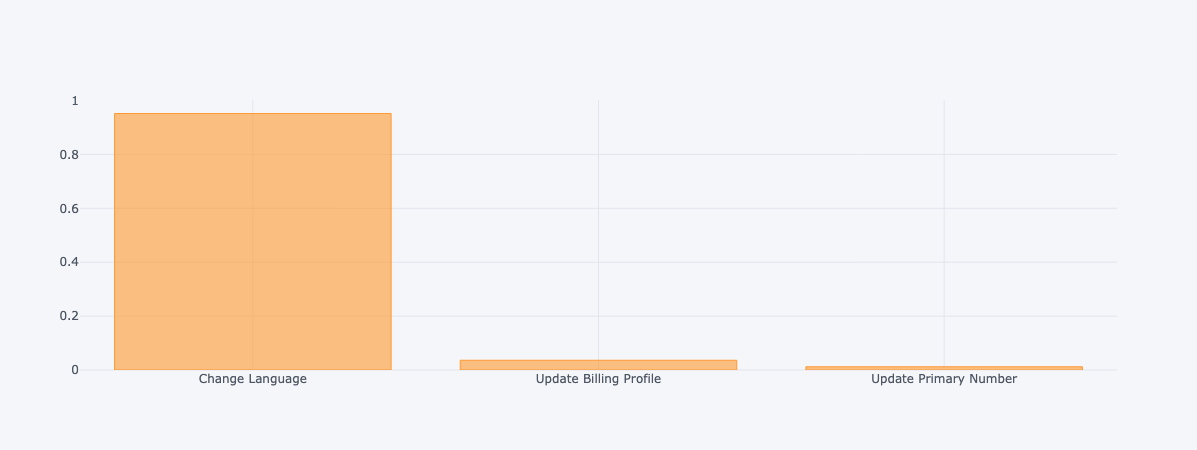

In [109]:
cc_df.loc[cc_df.Subscriber_ID.isin(case_1_ids)]['CNTCT_AREA_TYP_NME'].value_counts('%').iplot(kind='bar')

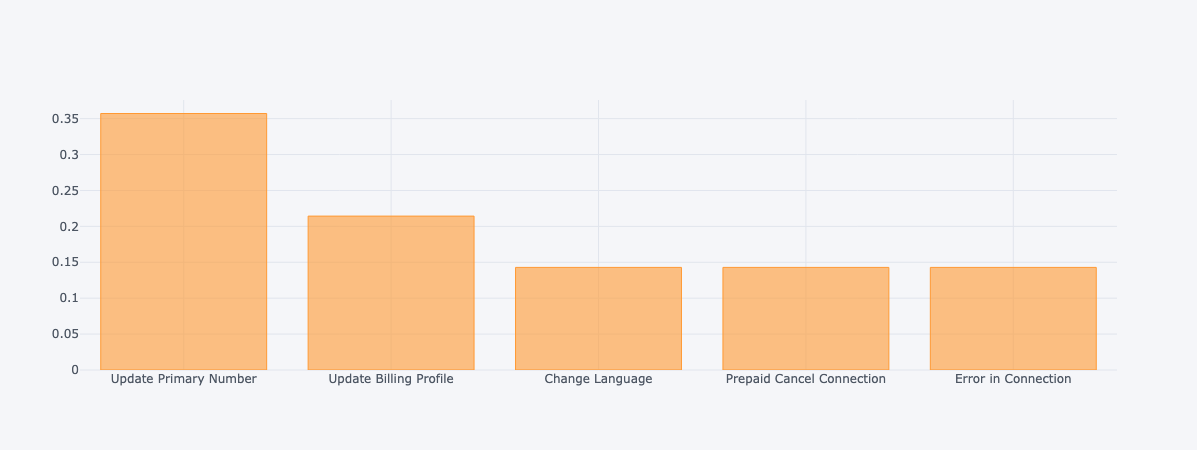

In [106]:
cc_df.loc[cc_df.Subscriber_ID.isin(case_2_ids)]['CNTCT_AREA_TYP_NME'].value_counts('%').iplot(kind='bar')

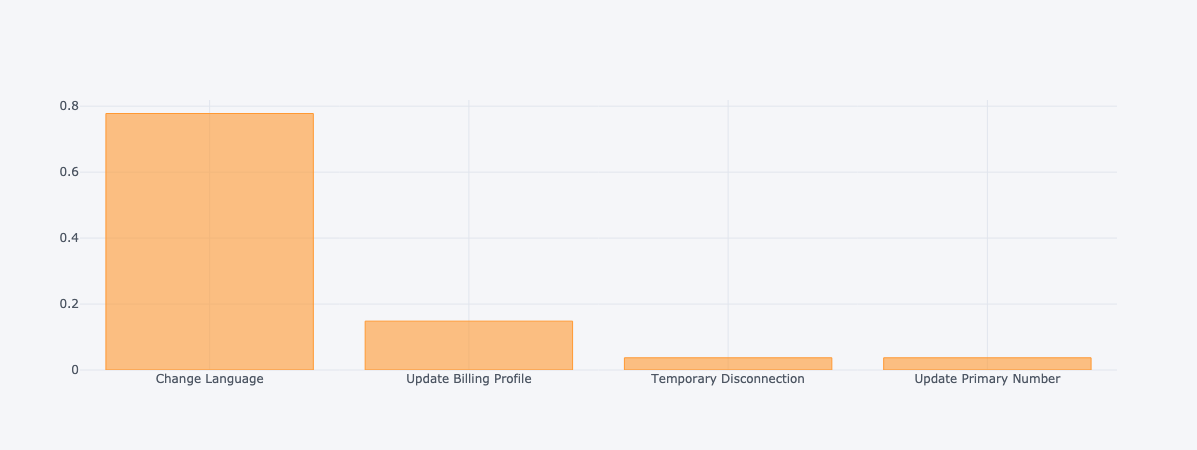

In [110]:
cc_df.loc[cc_df.Subscriber_ID.isin(case_3_ids)]['CNTCT_AREA_TYP_NME'].value_counts('%').iplot(kind='bar')

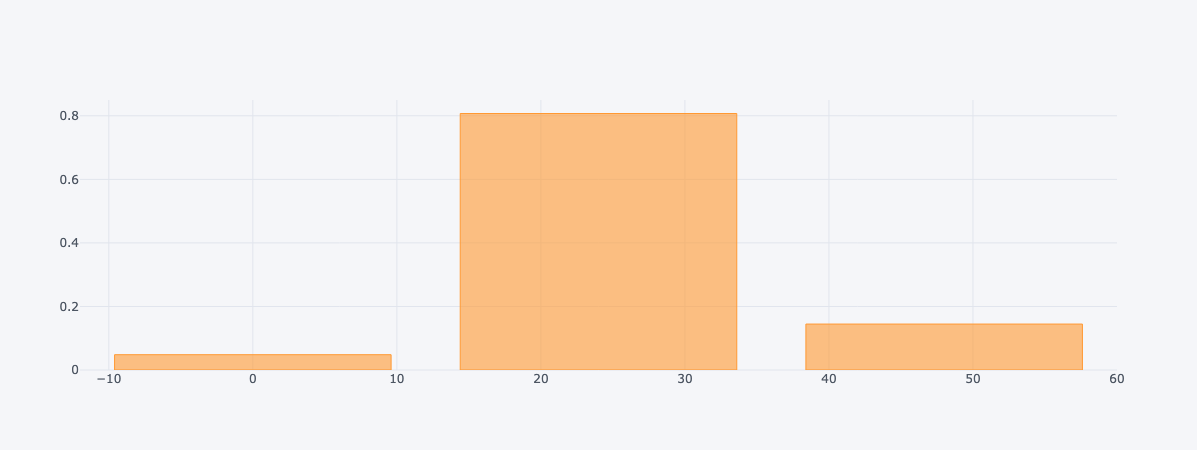

In [114]:
cc_df.loc[cc_df.Subscriber_ID.isin(case_1_ids)]['COMMIT_DUR'].value_counts('%').iplot(kind='bar')

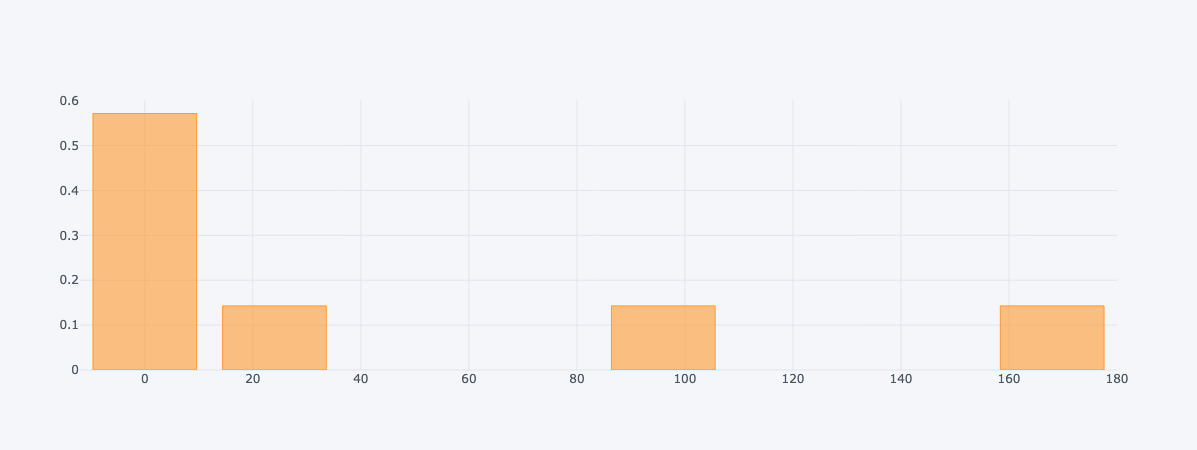

In [115]:
cc_df.loc[cc_df.Subscriber_ID.isin(case_2_ids)]['COMMIT_DUR'].value_counts('%').iplot(kind='bar')

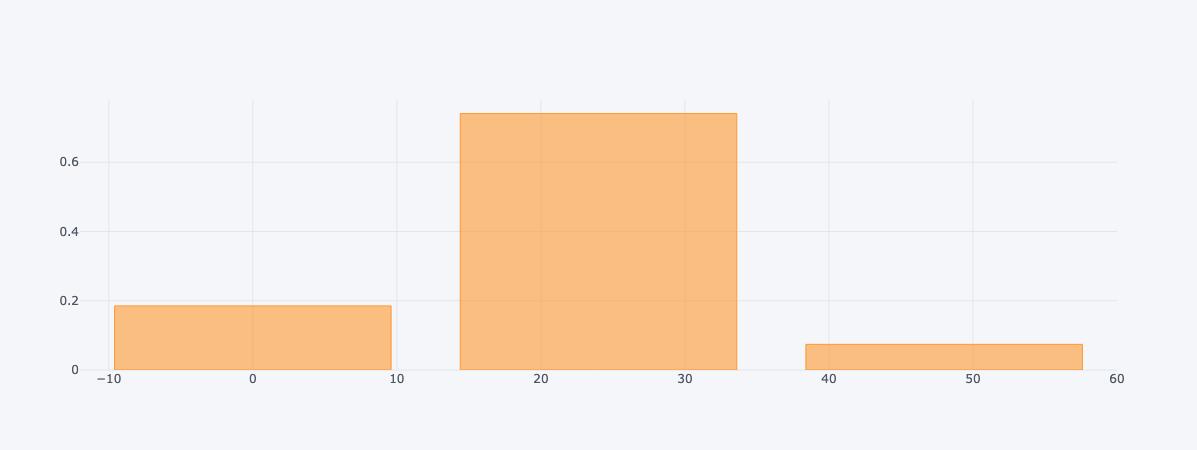

In [116]:
cc_df.loc[cc_df.Subscriber_ID.isin(case_3_ids)]['COMMIT_DUR'].value_counts('%').iplot(kind='bar')

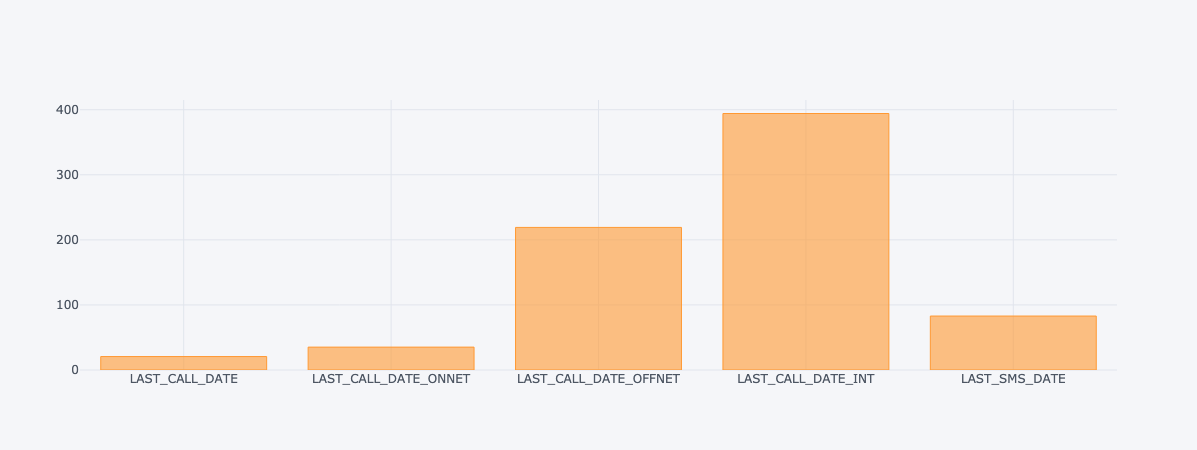

In [117]:
base_df.loc[base_df.Subscriber_ID.isin(case_1_ids)][["LAST_CALL_DATE", 
                                                     "LAST_CALL_DATE_ONNET", 
                                                     "LAST_CALL_DATE_OFFNET", 
                                                     "LAST_CALL_DATE_INT", 
                                                     "LAST_SMS_DATE"]].mean().iplot(kind='bar')

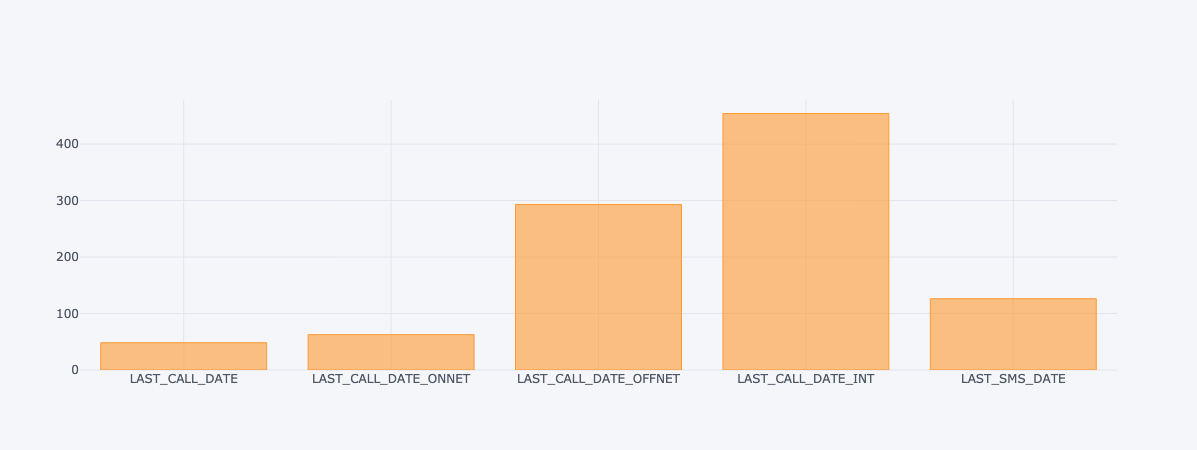

In [118]:
base_df.loc[base_df.Subscriber_ID.isin(case_2_ids)][["LAST_CALL_DATE", 
                                                     "LAST_CALL_DATE_ONNET", 
                                                     "LAST_CALL_DATE_OFFNET", 
                                                     "LAST_CALL_DATE_INT", 
                                                     "LAST_SMS_DATE"]].mean().iplot(kind='bar')

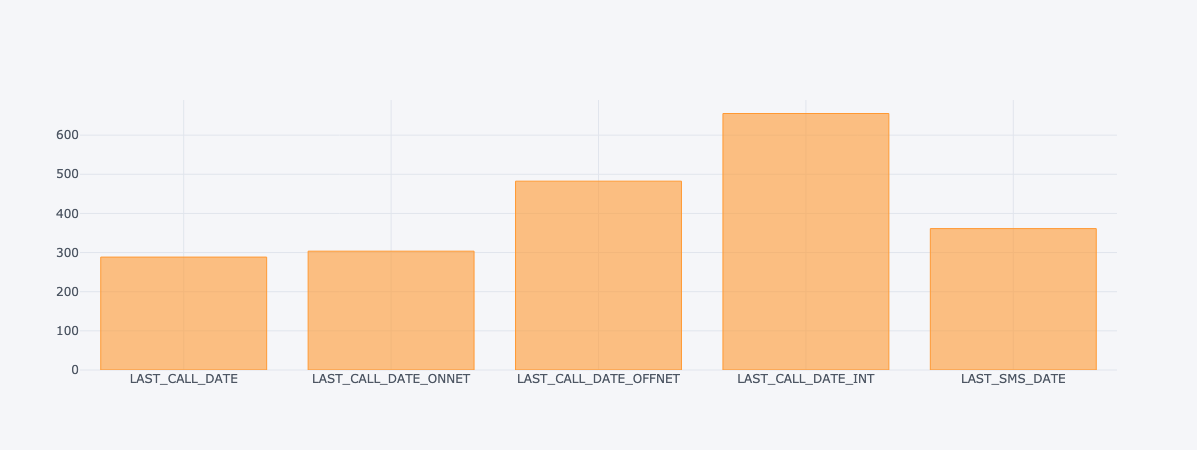

In [119]:
base_df.loc[base_df.Subscriber_ID.isin(case_3_ids)][["LAST_CALL_DATE", 
                                                     "LAST_CALL_DATE_ONNET", 
                                                     "LAST_CALL_DATE_OFFNET", 
                                                     "LAST_CALL_DATE_INT", 
                                                     "LAST_SMS_DATE"]].mean().iplot(kind='bar')

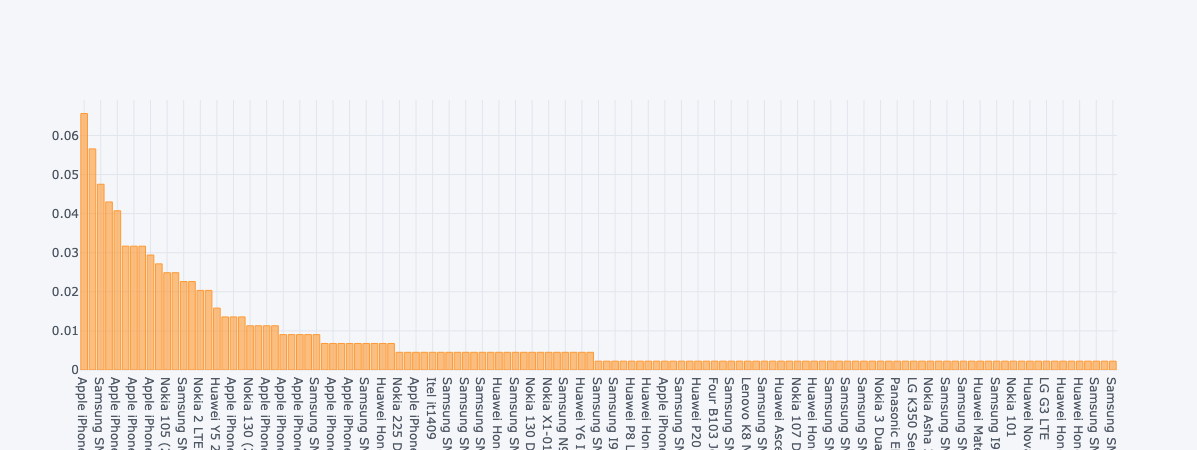

In [120]:
base_df.loc[base_df.Subscriber_ID.isin(case_1_ids)]["BRAND_MODEL"].value_counts('%').iplot(kind='bar')

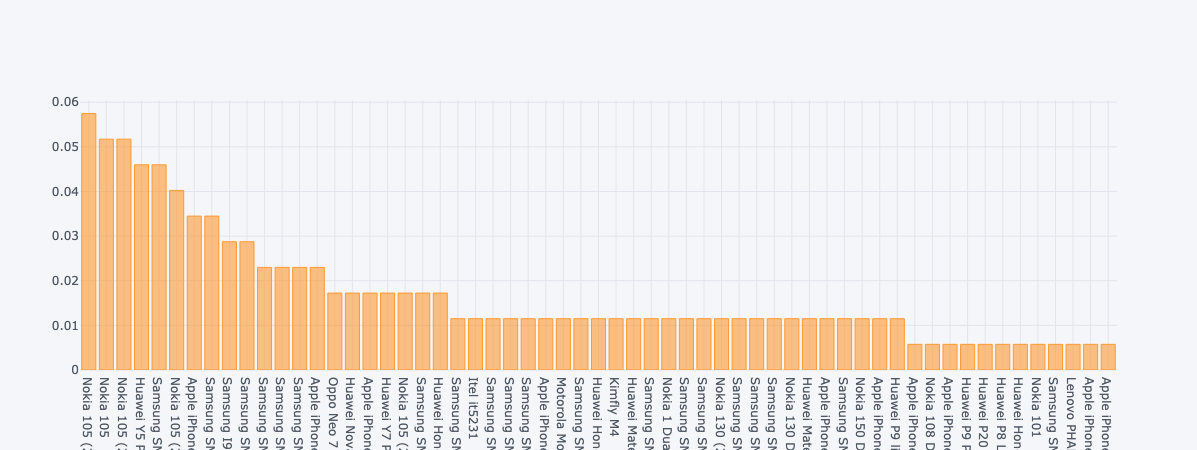

In [121]:
base_df.loc[base_df.Subscriber_ID.isin(case_2_ids)]["BRAND_MODEL"].value_counts('%').iplot(kind='bar')

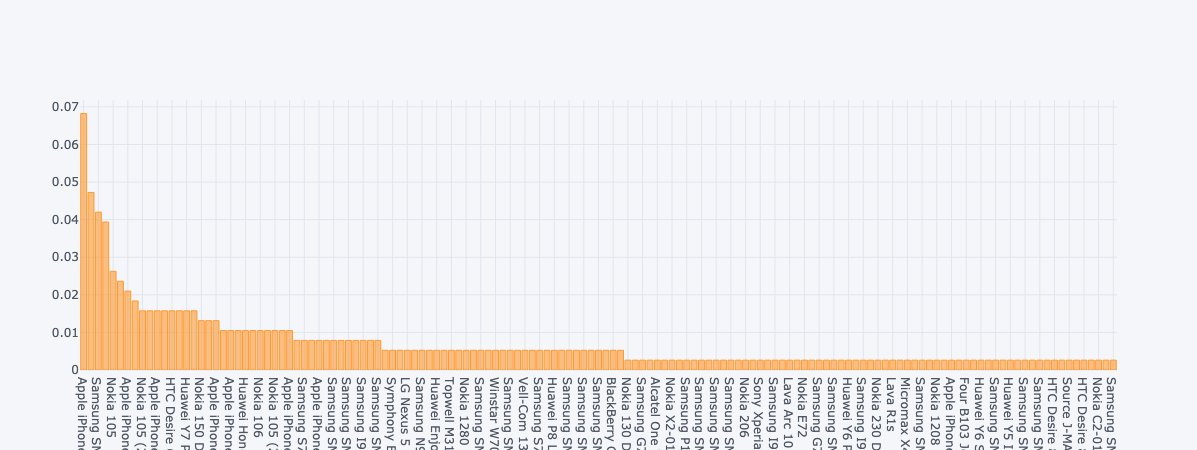

In [122]:
base_df.loc[base_df.Subscriber_ID.isin(case_3_ids)]["BRAND_MODEL"].value_counts('%').iplot(kind='bar')

Subscriber_ID CNTCT_EVNT_TM CNTCT_AREA_NME         CNTCT_AREA_TYP_NME  \
4             676      01:38:38        Service  Prepaid Cancel Connection   
36            677      01:38:38        Service  Prepaid Cancel Connection   

   CNTCT_EVNT_TYP_CD EXP_CLOSE_DT EXP_CLOSE_TM        EVNT_STRT_DTTM  \
4                  R  08-Apr-2019     07:00:00  01-Apr-2019 01:38:38   
36                 R  08-Apr-2019     07:00:00  01-Apr-2019 01:38:38   

           EVNT_END_DTTM CNTCT_TIER_CD CNTCT_CLSFCTON_CD     DUR  COMMIT_DUR  
4   05-Apr-2019 05:39:18        Tier 2         Technical  100.02       168.0  
36  05-Apr-2019 05:39:18        Tier 2         Technical  100.02       168.0

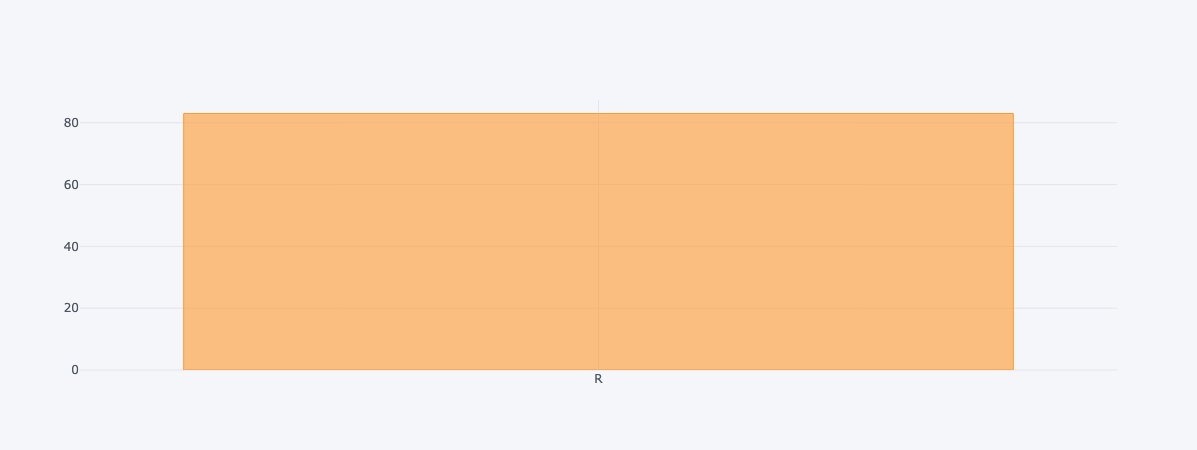

In [126]:
cc_df["CNTCT_EVNT_TYP_CD"].loc[cc_df.Subscriber_ID.isin(case_1_ids)].value_counts().iplot(kind='bar')

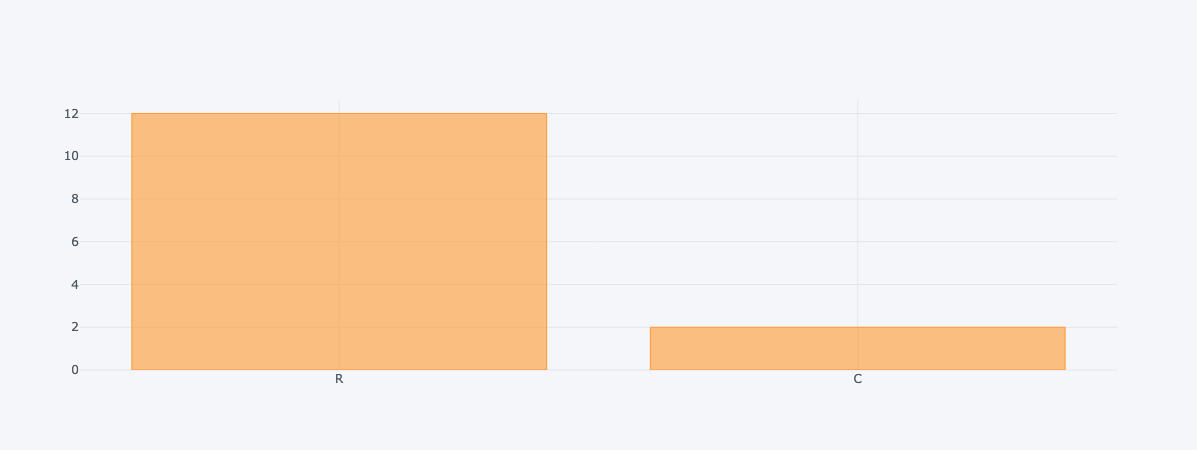

In [127]:
cc_df["CNTCT_EVNT_TYP_CD"].loc[cc_df.Subscriber_ID.isin(case_2_ids)].value_counts().iplot(kind='bar')

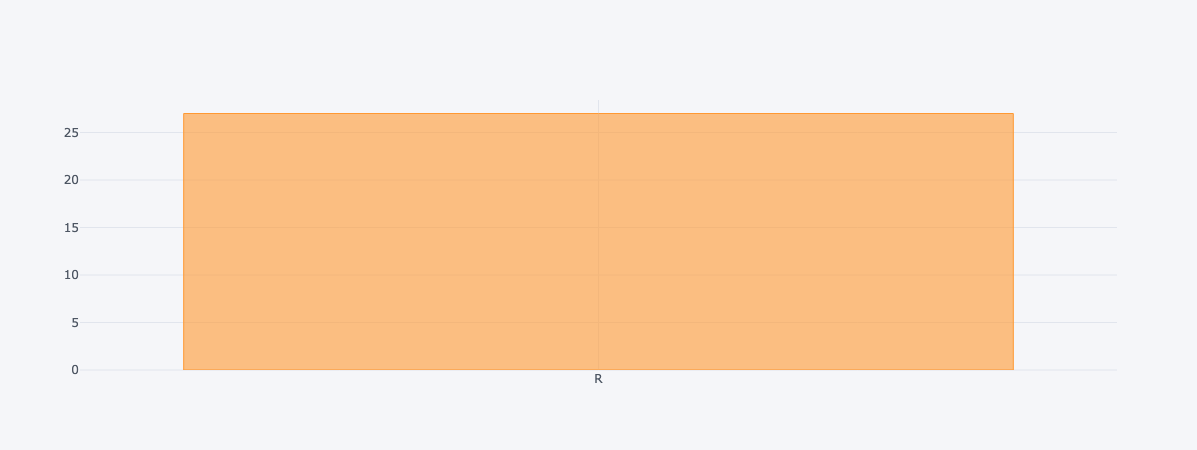

In [128]:
cc_df["CNTCT_EVNT_TYP_CD"].loc[cc_df.Subscriber_ID.isin(case_3_ids)].value_counts().iplot(kind='bar')